In [99]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle as pkl
import utils
sys.path.append('/home/jungyoung/Project/hh_neuralnet/include/')
import hhtools
import hhsignal
import importlib
from tqdm.notebook import tqdm
# other options
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.facecolor'] = 'w'
np.set_printoptions(suppress=True)
import xarray as xa
import hhclustering as hc

from numba import jit

from importlib import reload

reload(hc)

<module 'hhclustering' from '/home/jungyoung/Project/hh_neuralnet/dynamics_clustering/hhclustering.py'>

- Run after running 'find_proper_k.ipynb'

# Hierarchical clustering with optimal K

In [98]:
import hhclustering as hc


def sort_matrix(dist_mat, method="ward"):
    
    from scipy.spatial.distance import squareform
    from scipy.cluster.hierarchy import linkage
    
    def seriation(linkage_data, cur_index):
        if cur_index < N:
            return [cur_index]
        else:
            left = int(linkage_data[cur_index-N, 0])
            right = int(linkage_data[cur_index-N, 1])
            return (seriation(linkage_data, left) + seriation(linkage_data, right))
    
    flag_flip = False
    if np.all(np.diag(dist_mat) == 1):
        print("convert to distance metric")
        flag_flip = True
        dist_mat = 1 - dist_mat
    
    N = len(dist_mat)
    square_mat = squareform(dist_mat)
    res_linkage = linkage(square_mat, method=method)
    res_order   = seriation(res_linkage, 2*N-2)
    
    sort_mat = dist_mat.copy()
    sort_mat = sort_mat[res_order, :]
    sort_mat = sort_mat[:, res_order]
    
    if flag_flip:
        sort_mat = 1 - sort_mat
    
    return sort_mat, res_linkage, res_order


def hierarchical_clustering(dist_mat, num_clusters, method="average"):
    from sklearn.cluster import AgglomerativeClustering 
    # from scipy.spatial.distance import squareform
    
    if np.all(np.diag(dist_mat) == 1):
        print("convert to distance metric")
        dist_mat = 1 - dist_mat
    
    # aggcluster = AgglomerativeClustering(n_clusters=num_clusters, metric='euclidean', linkage="ward")
    aggcluster = AgglomerativeClustering(n_clusters=num_clusters, metric='precomputed', linkage=method)
    cluster_id = aggcluster.fit_predict(dist_mat.copy())
    cluster_id = cluster_id - np.min(cluster_id) + 1

    return cluster_id


def restore_permutation(permuted_arr, permuted_id):
    arr = np.zeros_like(permuted_arr)
    for n, nid in enumerate(permuted_id):
        arr[nid] = permuted_arr[n]
    return arr


def draw_with_dendrogram(res_linkage, cmat, cluster_id, label=None):
    from scipy.cluster.hierarchy import dendrogram
    
    num = res_linkage.shape[0]
    
    fig = plt.figure(dpi=120, figsize=(6, 6))
    fig.add_axes([0.15, 0.78, 0.65, 0.2])
    dendrogram(res_linkage, no_labels=True, color_threshold=max(res_linkage[:, 2]))
    # dendrogram(res_link, no_labels=True, color_threshold=max(res_link[:, 2])*1)
    plt.yscale("symlog")
    plt.xticks([]); plt.yticks([])
    # plt.xlim([0, num-1])

    fig.add_axes([0.15, 0.75, 0.65, 0.03])
    plt.imshow(cluster_id.reshape((1, -1)), aspect="auto", cmap="Set3", interpolation="none")
    for cid in np.unique(cluster_id):
        x = np.where(cluster_id == cid)[0]
        plt.text(np.average(x), 0, "%d"%(cid), ha='center', va="center")
    plt.xticks([]); plt.yticks([])
    plt.xlim([0, num-1])

    fig.add_axes([0.15, 0.1, 0.65, 0.65])
    plt.imshow(cmat, cmap="jet")
    plt.xlabel(label, fontsize=14)
    plt.ylabel(label, fontsize=14)

    # plt.show()
    return fig

def restore_order(order):
    rev_order = np.zeros_like(order)
    for n, o in enumerate(order):
        rev_order[o] = n
    return rev_order

In [3]:
with open("./data/kmeans_tot_opt.pkl", 'rb') as fp:
    cmat_data_tot = pkl.load(fp)
print("opt K: %d"%(cmat_data_tot["num_cluster"]))
    
with open("./data/kmeans_sub_opt.pkl", 'rb') as fp:
    cmat_data_sub = pkl.load(fp)
print("opt K: %d"%(cmat_data_sub["num_cluster"]))

opt K: 7
opt K: 8


## Clustering

In [188]:
# select data type

tag = "sub"

cmat_data = cmat_data_sub
align_data = utils.load_pkl("./data/align_data_%s.pkl"%(tag))

## Hierarchical clustering

In [147]:
dist_mat = 1 - cmat_data["consensus_mat"].copy()
model = hc.SLHC(metric="precomputed", method="complete")
model.fit(dist_mat)

In [187]:
sorted_mat, sort_id = model.sort_dmat(cmat_data["consensus_mat"].copy())
cluster_id = model.cut_dend(N=8)

In [202]:
sval_old, _ = hc.get_silhouette_scores(align_data["data"], cluster_id)

""" Denoising """
sz = (15, 15, 3, 16)

sq_cid = cluster_id.reshape(*sz)
sq_sval = sval_old.reshape(*sz)

sq_cid_r = np.zeros_like(sq_cid)
for nr in range(sq_cid_r.shape[2]):
    for nw in range(sq_cid_r.shape[3]):
        sq_tmp = hc.denoise_square_cluster(sq_cid[:, :, nr, nw], sq_sval=sq_sval[:,:,nr,nw])
        sq_cid_r[:, :, nr, nw] = hc.remove_cluster_island(sq_tmp, nth=2)

sq_cid_r, changed_id = hc.reorder_sq_cluster_id(sq_cid_r, start_id=1)

cluster_id, cluster_id_old = sq_cid_r.flatten(), cluster_id
sval, scoef = hc.get_silhouette_scores(align_data["data"], cluster_id)

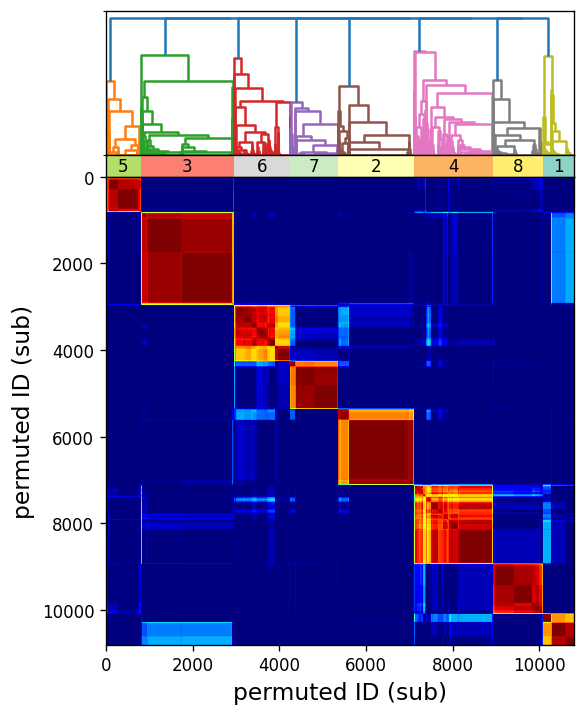

In [201]:
tmp_id = np.zeros_like(cluster_id_old)
for id_prv, id_new in changed_id.items():
    tmp_id[cluster_id_old == id_prv] = id_new

fig = draw_with_dendrogram(model.linkmat, sorted_mat, tmp_id[sort_id], label="permuted ID (%s)"%(tag))

## Save result

In [210]:
with open("./data/slhc_obj_%s.pkl"%(tag), "wb") as fp:
    pkl.dump(model, fp)

In [209]:
import xarray as xa

postdata = xa.load_dataarray("../three_pop_mpi/simulation_data/postdata.nc")

dims = ("alpha", "beta", "rank", "w")
coords = coords=dict(
            alpha=postdata.coords["alpha"].data,
            beta=postdata.coords["beta"].data,
            rank=postdata.coords["rank"].data,
            w=postdata.coords["w"].data
        )

cid_dataset = xa.Dataset(
    data_vars=dict(
        cluster_id=(dims, cluster_id.reshape(*sz)),
        sval=(dims, sval.reshape(*sz))
    ),
    coords=coords,
    attrs=dict(
        id_set=np.unique(cluster_id),
        date=utils.get_date_string(),
        scoef=scoef
    )
)

cid_dataset.to_netcdf("./data/cluster_id_%s.nc"%(tag))

## Cluster denoising & Align dataset

In [171]:
def show_aligned_data(data, cluster_id, sval, yticks):
    
    def draw_line(bds):
        xl = plt.xlim()
        yl = plt.ylim()
        for b in bds:
            plt.plot([b]*2, yl, 'k', lw=0.5)
        plt.xlim(xl); plt.ylim(yl)
    
    data_o, _, bds = hc.reorder_data(data, cluster_id, sval)
    
    fig = plt.figure(figsize=(4, int(0.3*data_o.shape[0])), dpi=120)
    im = hc.hsmooth(data_o, wsize=15, fo=2)
    plt.imshow(im, cmap="jet", interpolation="none", aspect="auto", vmin=-2, vmax=2)
    draw_line(bds)
    plt.xticks([])
    plt.yticks()
    plt.xlabel("Data points", fontsize=14)
    plt.yticks(np.arange(im.shape[0]), labels=yticks)
    plt.colorbar(shrink=0.3, ticks=[-2, 0, 2])
    
    return fig

In [165]:
align_data = utils.load_pkl("./data/align_data_%s.pkl"%(tag))
sval, scoef = hc.get_silhouette_scores(align_data["data"], cluster_id)

In [173]:
# reload(hc)

""" Denoising """
sz = (15, 15, 3, 16)

sq_cid = cluster_id.reshape(*sz)
sq_sval = sval.reshape(*sz)

sq_cid_r = np.zeros_like(sq_cid)
for nr in range(sq_cid_r.shape[2]):
    for nw in range(sq_cid_r.shape[3]):
        sq_tmp = hc.denoise_square_cluster(sq_cid[:, :, nr, nw], sq_sval=sq_sval[:,:,nr,nw])
        sq_cid_r[:, :, nr, nw] = hc.remove_cluster_island(sq_tmp, nth=2)

sq_cid_r, changed_id = hc.reorder_sq_cluster_id(sq_cid_r, start_id=1)    

In [174]:
cluster_id_tmp = np.zeros_like(cluster_id)
for nc in np.unique(cluster_id):
    cluster_id_tmp[cluster_id == nc] = changed_id[nc]

In [177]:
changed_id

{1: 1, 2: 8, 3: 4, 4: 2, 5: 6, 6: 3, 7: 5, 8: 7}

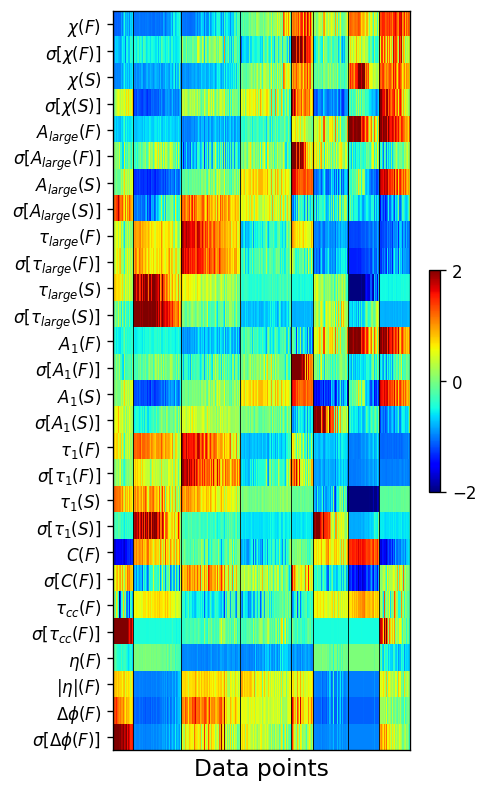

In [175]:
cluster_id_tmp = np.zeros_like(cluster_id)
for nc in np.unique(cluster_id):
    cluster_id_tmp[cluster_id == nc] = changed_id[nc]

fig = show_aligned_data(align_data["data"], cluster_id_tmp, sval, align_data["row_labels"])
# utils.save_fig("./ordered_data_%s"%(tag), fdir="./fig")

## TSNE

In [13]:
from sklearn.manifold import TSNE

np.random.seed(300)

tsne2d = TSNE(n_components=2, init="pca")
tsne_fit_2d = tsne2d.fit_transform(align_data["data"].copy().T)

In [14]:
def draw_with_tsne2d(**kwargs):
    plt.scatter(tsne_fit_2d[:, 0], tsne_fit_2d[:, 1], **kwargs)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("Axis 1", fontsize=13)
    plt.ylabel("Axis 2", fontsize=13)
    for side in ['top','right','bottom','left']:
        plt.gca().spines[side].set_visible(False)

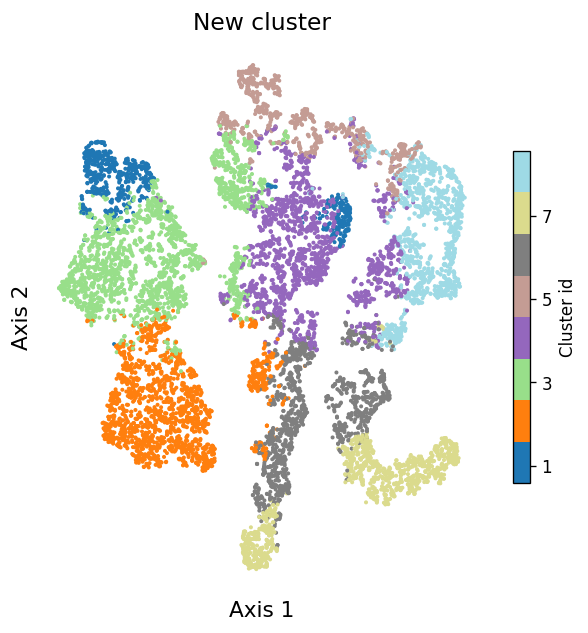

In [15]:
cmap = plt.get_cmap("tab20", 8)

plt.figure(dpi=120, figsize=(6, 6))

draw_with_tsne2d(s=2, c=sq_cid_r.flatten(), cmap=cmap)
plt.title("New cluster", fontsize=14)
utils.draw_categorical_colorbar(n_category=8, label="Cluster id", shrink=0.6)

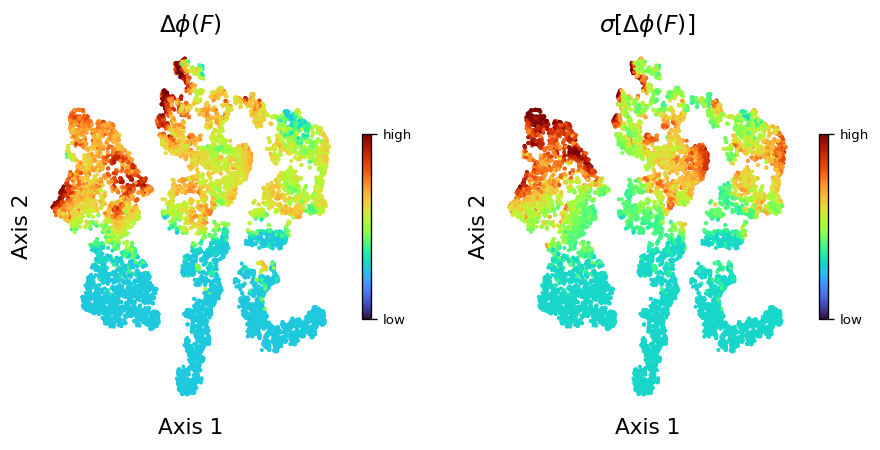

In [38]:
cmap = plt.get_cmap("turbo")

def id_finder(name, target_name):
    try:
        return name.index(target_name)
    except ValueError:
        print(target_name, "not exist in input")
        return None

plt.figure(dpi=120, figsize=(9, 4))
for n, tag in enumerate(("dphi(F)", "dphi(F)_std")):
    plt.subplot(1,2,n+1)
    
    nid = id_finder(align_data["row_names"], tag)
    draw_with_tsne2d(s=2, c=align_data["data"][nid, :], cmap=cmap, vmin=-2.5, vmax=2.5)
    plt.title(align_data["row_labels"][nid], fontsize=14)
    cbar = plt.colorbar(shrink=0.5, ticks=[-2.5, 2.5])
    cbar.set_ticklabels(["low", "high"], rotation=0, fontsize=8)
    
# utils.save_fig("tSNE_chi")
plt.show()

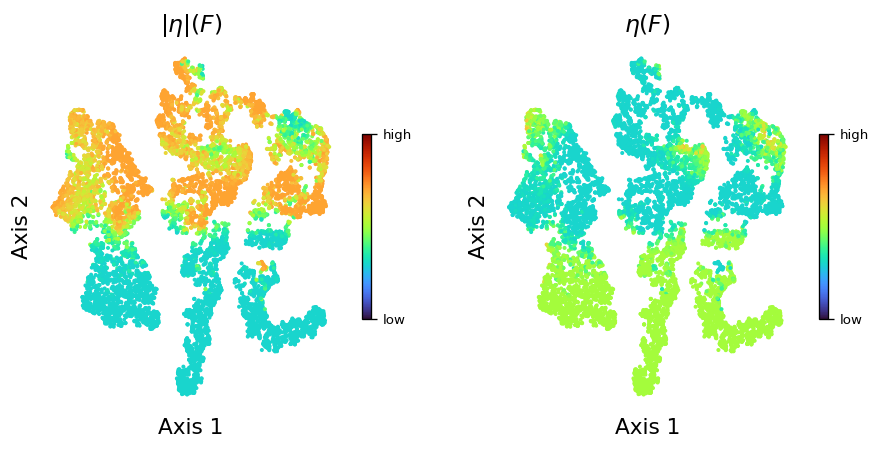

In [35]:
cmap = plt.get_cmap("turbo")

def id_finder(name, target_name):
    try:
        return name.index(target_name)
    except ValueError:
        print(target_name, "not exist in input")
        return None

plt.figure(dpi=120, figsize=(9, 4))
for n, tag in enumerate(("leading_ratio(abs)(F)", "leading_ratio(F)")):
    plt.subplot(1,2,n+1)
    
    nid = id_finder(align_data["row_names"], tag)
    draw_with_tsne2d(s=2, c=align_data["data"][nid, :], cmap=cmap, vmin=-2.5, vmax=2.5)
    plt.title(align_data["row_labels"][nid], fontsize=14)
    cbar = plt.colorbar(shrink=0.5, ticks=[-2.5, 2.5])
    cbar.set_ticklabels(["low", "high"], rotation=0, fontsize=8)
    
# utils.save_fig("tSNE_chi")
plt.show()

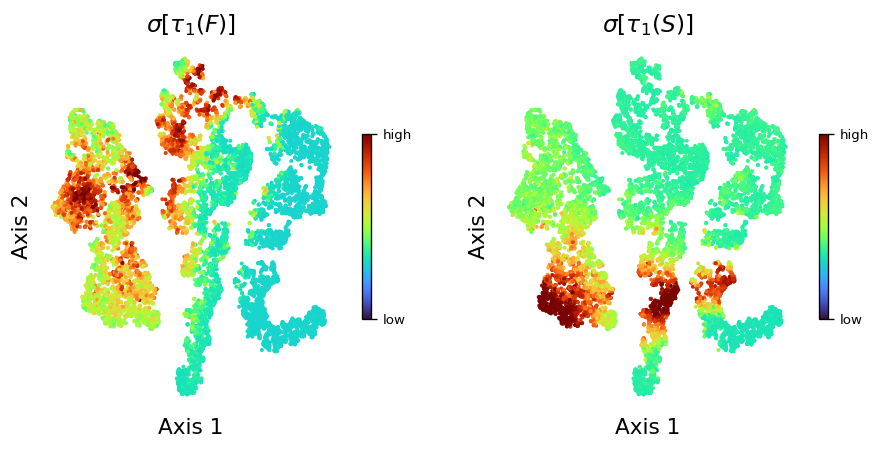

In [20]:
cmap = plt.get_cmap("turbo")

def id_finder(name, target_name):
    try:
        return name.index(target_name)
    except ValueError:
        print(target_name, "not exist in input")
        return None

plt.figure(dpi=120, figsize=(9, 4))
for n, tag in enumerate(("tlag_1st(F)_std", "tlag_1st(S)_std")):
    plt.subplot(1,2,n+1)
    
    nid = id_finder(align_data["row_names"], tag)
    draw_with_tsne2d(s=2, c=align_data["data"][nid, :], cmap=cmap, vmin=-2.5, vmax=2.5)
    plt.title(align_data["row_labels"][nid], fontsize=14)
    cbar = plt.colorbar(shrink=0.5, ticks=[-2.5, 2.5])
    cbar.set_ticklabels(["low", "high"], rotation=0, fontsize=8)
    
# utils.save_fig("tSNE_chi")
plt.show()

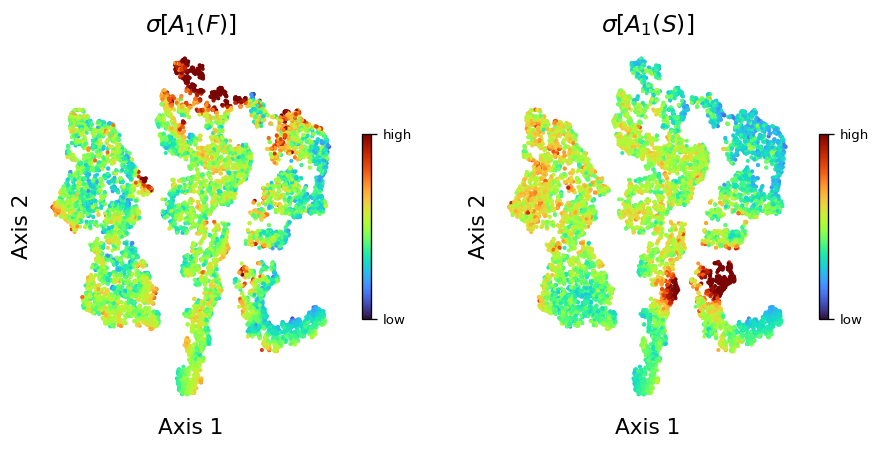

In [21]:
cmap = plt.get_cmap("turbo")

def id_finder(name, target_name):
    try:
        return name.index(target_name)
    except ValueError:
        print(target_name, "not exist in input")
        return None

plt.figure(dpi=120, figsize=(9, 4))
for n, tag in enumerate(("ac2p_1st(F)_std", "ac2p_1st(S)_std")):
    plt.subplot(1,2,n+1)
    
    nid = id_finder(align_data["row_names"], tag)
    draw_with_tsne2d(s=2, c=align_data["data"][nid, :], cmap=cmap, vmin=-2.5, vmax=2.5)
    plt.title(align_data["row_labels"][nid], fontsize=14)
    cbar = plt.colorbar(shrink=0.5, ticks=[-2.5, 2.5])
    cbar.set_ticklabels(["low", "high"], rotation=0, fontsize=8)
    
# utils.save_fig("tSNE_chi")
plt.show()

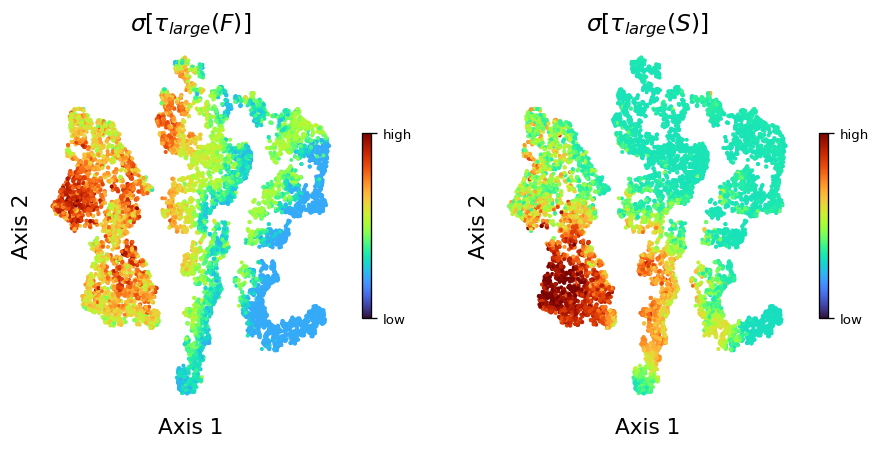

In [22]:
cmap = plt.get_cmap("turbo")

def id_finder(name, target_name):
    try:
        return name.index(target_name)
    except ValueError:
        print(target_name, "not exist in input")
        return None

plt.figure(dpi=120, figsize=(9, 4))
for n, tag in enumerate(("tlag_large(F)_std", "tlag_large(S)_std")):
    plt.subplot(1,2,n+1)
    
    nid = id_finder(align_data["row_names"], tag)
    draw_with_tsne2d(s=2, c=align_data["data"][nid, :], cmap=cmap, vmin=-2.5, vmax=2.5)
    plt.title(align_data["row_labels"][nid], fontsize=14)
    cbar = plt.colorbar(shrink=0.5, ticks=[-2.5, 2.5])
    cbar.set_ticklabels(["low", "high"], rotation=0, fontsize=8)
    
# utils.save_fig("tSNE_chi")
plt.show()

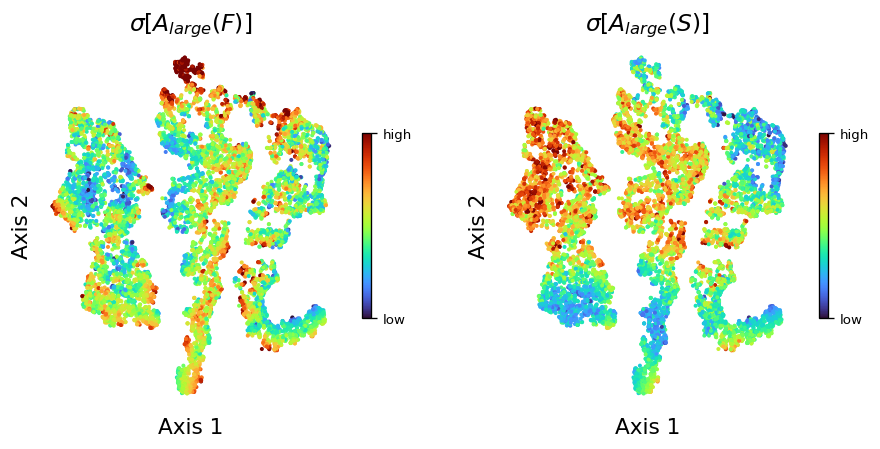

In [23]:
cmap = plt.get_cmap("turbo")

def id_finder(name, target_name):
    try:
        return name.index(target_name)
    except ValueError:
        print(target_name, "not exist in input")
        return None

plt.figure(dpi=120, figsize=(9, 4))
for n, tag in enumerate(("ac2p_large(F)_std", "ac2p_large(S)_std")):
    plt.subplot(1,2,n+1)
    
    nid = id_finder(align_data["row_names"], tag)
    draw_with_tsne2d(s=2, c=align_data["data"][nid, :], cmap=cmap, vmin=-2.5, vmax=2.5)
    plt.title(align_data["row_labels"][nid], fontsize=14)
    cbar = plt.colorbar(shrink=0.5, ticks=[-2.5, 2.5])
    cbar.set_ticklabels(["low", "high"], rotation=0, fontsize=8)
    
# utils.save_fig("tSNE_chi")
plt.show()

save to ./fig/./ordered_data_sub_20231010.png


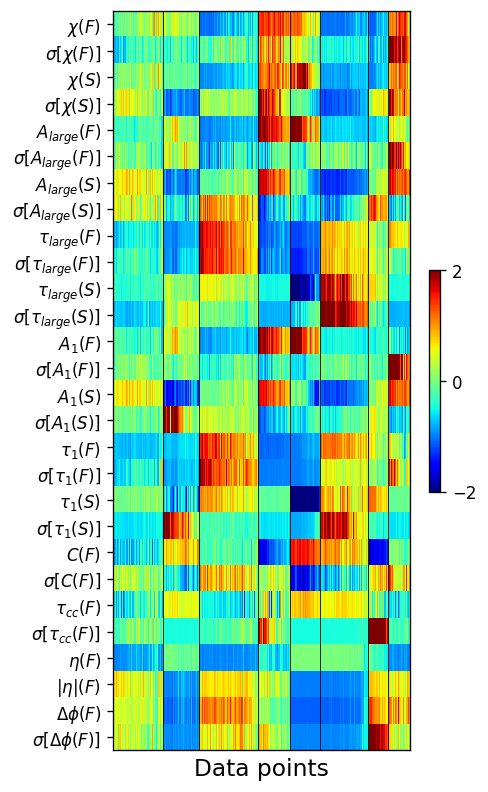

In [14]:
fig = show_aligned_data(align_data["data"], sq_cid.flatten(), sval, align_data["row_labels"])
utils.save_fig("./ordered_data_%s"%(tag), fdir="./fig")

In [46]:
# get lines
def get_im_boundary(im):
    nb = im.shape[0]
    lines = []
    
    def is_out(nr, nc):
        return (nc < 0) or (nc >=nb) or (nr < 0) or (nr >= nb)
    
    for i in range(nb):
        for j in range(nb):
            for d in ((-1, 0), (1, 0), (0, -1), (0, 1)):
                r, c = i+d[0], j+d[1]
                if is_out(r, c): continue
                
                if im[i, j] != im[r, c]:
                    if d[1] == 0:
                        lines.append([[j-0.5, j+0.5], [i+0.5*d[0], i+0.5*d[0]]])
                    else:
                        lines.append([[j+0.5*d[1], j+0.5*d[1]], [i-0.5, i+0.5]])
    return lines


def show_cluster_summary(cluster_id, wsets=None, max_cid=15, min_cid=1, sval=None, sth=0.2):
    
    num_w = 16
    num_r = 3
    
    len_p = 0.95/num_w
    len_r = 0.95/num_r

    xy = np.arange(15)

    lb_rank = ("Echelon 0", "Echelon 0.5", "Echelon 1")
    # lb_w = [r"$\omega$=%.1f"%(x) for x in np.linspace(0.1, 1, 7)]
    # lb_w = [r"$\omega$=%.1f"%(x) for x in np.linspace(0.1, 1, 7)]
    lb_w = [r"$\omega$=%.2f"%(x) for x in wsets]
    
    lines_cluster = []
    for idp in range(num_w):
        for idr in range(num_r):
            lines_cluster.append(get_im_boundary(cluster_id[:, :, idr, idp]))

    ax_sets = []
    # fig = plt.figure(dpi=120, figsize=(14, 6))
    fig = plt.figure(dpi=120, figsize=(20, 4))
    for idp in range(num_w):
        ax_sets.append([])
        for idr in range(num_r):
            ax = plt.axes(position=[0.025+len_p*idp, 0.025+(2-idr)*len_r, len_p, len_r])
            ax_sets[-1].append(ax)
            
            # im = cluster_data["im_stacks"][idr][idp].astype(float)
            im = cluster_id[:, :, idr, idp].astype(float)
            im[0, 0] = np.nan
            
            if sval is not None:
                im[sval[:, :, idr, idp] < sth] = np.nan
            
            hc.show_sq_cluster(im, x=xy, y=xy, cmap="turbo", cth=2, vmin=min_cid, vmax=max_cid, fontsize=12, aspect="auto")
            for l in lines_cluster[idp*num_r+idr]:
                plt.plot(l[0], l[1], 'w', lw=1)
            
            plt.xticks([0, 7, 14], labels=["", "", ""])
            plt.yticks([0, 7, 14], labels=["", "", ""])
            plt.xlim([-0, 14]); plt.ylim([0, 14])
            
            if idp == 0:
                plt.ylabel(lb_rank[idr], fontsize=15, style="italic")
            
            if idr == 0:
                plt.title(lb_w[idp], fontsize=15, style="italic")
            
            for n, k in enumerate(("left", "right", "bottom", "top")):
                ax.spines[k].set_color("k")
                ax.spines[k].set_linewidth(1.5)

    # plt.show()
    return fig, ax_sets

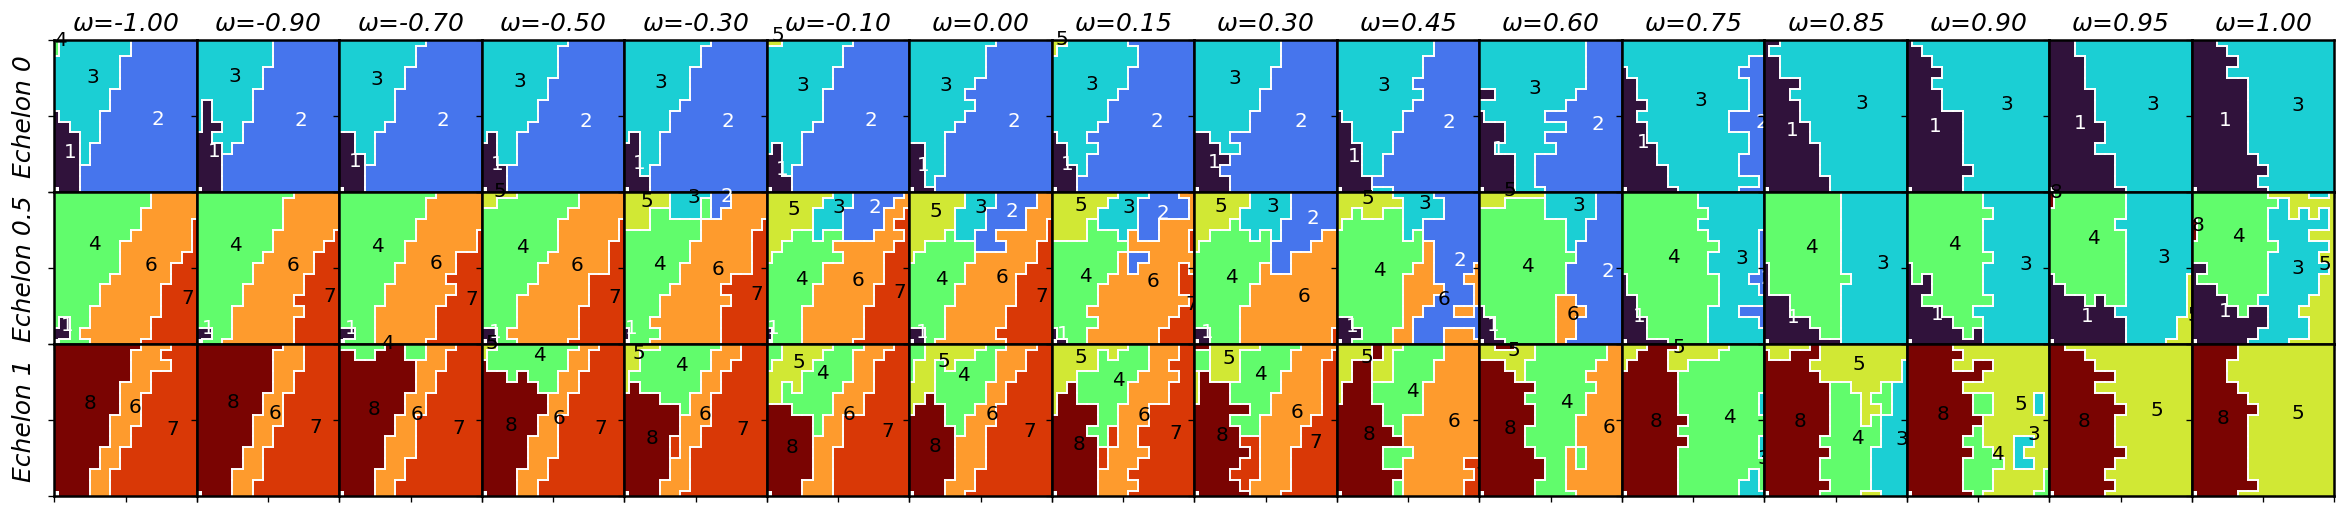

In [47]:
wset = [-1, -0.9, -0.7, -0.5, -0.3, -0.1, 0., 0.15, 0.3, 0.45, 0.6, 0.75, 0.85, 0.9, 0.95, 1]

show_cluster_summary(sq_cid_r, wsets=[-1, -0.9, -0.7, -0.5, -0.3, -0.1, 0., 0.15, 0.3, 0.45, 0.6, 0.75, 0.85, 0.9, 0.95, 1],
                     max_cid=np.max(sq_cid_r))
plt.show()

### Save

In [48]:
import xarray as xa

postdata = xa.load_dataarray("../three_pop_mpi/simulation_data/postdata.nc")

dims = ("alpha", "beta", "rank", "w")
coords = coords=dict(
            alpha=postdata.coords["alpha"].data,
            beta=postdata.coords["beta"].data,
            rank=postdata.coords["rank"].data,
            w=postdata.coords["w"].data
        )

cid_dataset = xa.Dataset(
    data_vars=dict(
        cluster_id=(dims, sq_cid_r),
        sval=(dims, sval.reshape(*sz))
    ),
    coords=coords,
    attrs=dict(
        id_set=np.unique(sq_cid_r),
        date=utils.get_date_string(),
        scoef=scoef
    )
)

cid_dataset.to_netcdf("./data/cluster_id_%s.nc"%(tag))

# Draw cluster lines on the data

In [19]:
import xarray as xa

# cid_dataset.to_netcdf("./data/cluster_id_%s.nc"%(tag))
cid_dataset = xa.load_dataset("./data/cluster_id_%s.nc"%(tag))
align_data = utils.load_pkl("./data/align_data_%s.pkl"%(tag))

In [46]:
# get lines
def get_im_boundary(im):
    nb = im.shape[0]
    lines = []
    
    def is_out(nr, nc):
        return (nc < 0) or (nc >=nb) or (nr < 0) or (nr >= nb)
    
    for i in range(nb):
        for j in range(nb):
            for d in ((-1, 0), (1, 0), (0, -1), (0, 1)):
                r, c = i+d[0], j+d[1]
                if is_out(r, c): continue
                
                if im[i, j] != im[r, c]:
                    if d[1] == 0:
                        lines.append([[j-0.5, j+0.5], [i+0.5*d[0], i+0.5*d[0]]])
                    else:
                        lines.append([[j+0.5*d[1], j+0.5*d[1]], [i-0.5, i+0.5]])
    return lines


def show_cluster_summary(cluster_id, wsets=None, max_cid=15, min_cid=1, sval=None, sth=0.2):
    
    num_w = 16
    num_r = 3
    
    len_p = 0.95/num_w
    len_r = 0.95/num_r

    xy = np.arange(15)

    lb_rank = ("Echelon 0", "Echelon 0.5", "Echelon 1")
    # lb_w = [r"$\omega$=%.1f"%(x) for x in np.linspace(0.1, 1, 7)]
    # lb_w = [r"$\omega$=%.1f"%(x) for x in np.linspace(0.1, 1, 7)]
    lb_w = [r"$\omega$=%.2f"%(x) for x in wsets]
    
    lines_cluster = []
    for idp in range(num_w):
        for idr in range(num_r):
            lines_cluster.append(get_im_boundary(cluster_id[:, :, idr, idp]))

    ax_sets = []
    # fig = plt.figure(dpi=120, figsize=(14, 6))
    fig = plt.figure(dpi=120, figsize=(20, 4))
    for idp in range(num_w):
        ax_sets.append([])
        for idr in range(num_r):
            ax = plt.axes(position=[0.025+len_p*idp, 0.025+(2-idr)*len_r, len_p, len_r])
            ax_sets[-1].append(ax)
            
            # im = cluster_data["im_stacks"][idr][idp].astype(float)
            im = cluster_id[:, :, idr, idp].astype(float)
            im[0, 0] = np.nan
            
            if sval is not None:
                im[sval[:, :, idr, idp] < sth] = np.nan
            
            hc.show_sq_cluster(im, x=xy, y=xy, cmap="turbo", cth=2, vmin=min_cid, vmax=max_cid, fontsize=12, aspect="auto")
            for l in lines_cluster[idp*num_r+idr]:
                plt.plot(l[0], l[1], 'w', lw=1)
            
            plt.xticks([0, 7, 14], labels=["", "", ""])
            plt.yticks([0, 7, 14], labels=["", "", ""])
            plt.xlim([-0, 14]); plt.ylim([0, 14])
            
            if idp == 0:
                plt.ylabel(lb_rank[idr], fontsize=15, style="italic")
            
            if idr == 0:
                plt.title(lb_w[idp], fontsize=15, style="italic")
            
            for n, k in enumerate(("left", "right", "bottom", "top")):
                ax.spines[k].set_color("k")
                ax.spines[k].set_linewidth(1.5)

    # plt.show()
    return fig, ax_sets

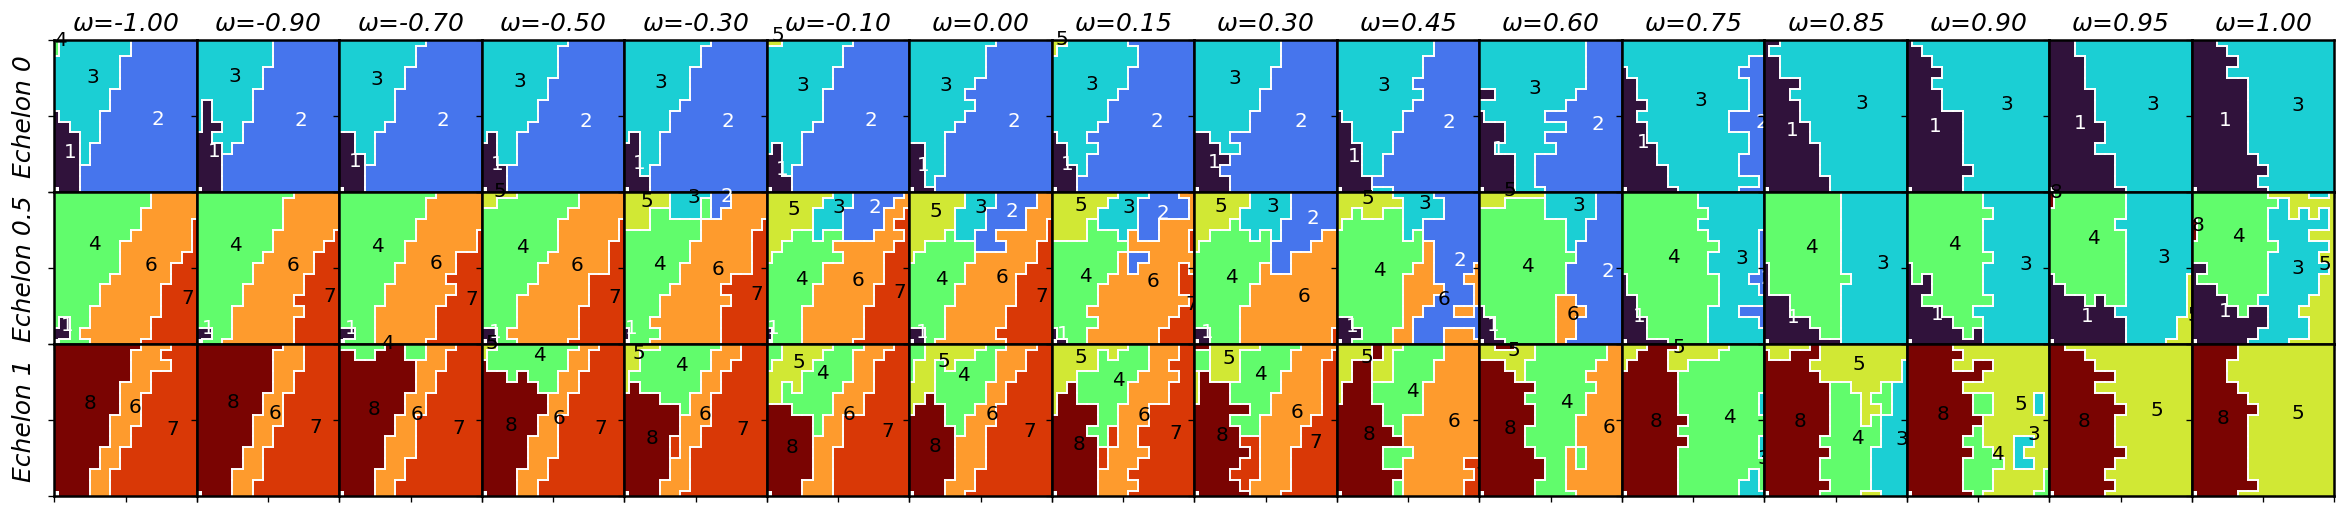

In [47]:
# wset = [-1, -0.9, -0.7, -0.5, -0.3, -0.1, 0., 0.15, 0.3, 0.45, 0.6, 0.75, 0.85, 0.9, 0.95, 1]

wset = cid_dataset.coords["w"].data
sq_cid = cid_dataset.cluster_id.data

show_cluster_summary(sq_cid, wsets=wset, max_cid=np.max(sq_cid))
# utils.save_fig("cluster_id_panel", fdir="./fig")
plt.show()

## Draw boundary line

In [20]:
sz = cid_dataset.cluster_id.shape
num = len(align_data["data"])
sq_data = align_data["data"].reshape([num]+list(sz))

from pprint import pprint
pprint(align_data["row_names"])

['chi(F)',
 'chi(F)_std',
 'chi(S)',
 'chi(S)_std',
 'ac2p_large(F)',
 'ac2p_large(F)_std',
 'ac2p_large(S)',
 'ac2p_large(S)_std',
 'tlag_large(F)',
 'tlag_large(F)_std',
 'tlag_large(S)',
 'tlag_large(S)_std',
 'ac2p_1st(F)',
 'ac2p_1st(F)_std',
 'ac2p_1st(S)',
 'ac2p_1st(S)_std',
 'tlag_1st(F)',
 'tlag_1st(F)_std',
 'tlag_1st(S)',
 'tlag_1st(S)_std',
 'cc1p(F)',
 'cc1p(F)_std',
 'tlag_cc(F)',
 'tlag_cc(F)_std',
 'leading_ratio(F)',
 'leading_ratio(abs)(F)',
 'dphi(F)',
 'dphi(F)_std']


In [51]:
lines_cluster[0]

[[[[2.5, 2.5], [-0.5, 0.5]],
  [[2.5, 2.5], [-0.5, 0.5]],
  [[2.5, 2.5], [0.5, 1.5]],
  [[2.5, 2.5], [0.5, 1.5]],
  [[2.5, 2.5], [1.5, 2.5]],
  [[2.5, 3.5], [2.5, 2.5]],
  [[2.5, 2.5], [1.5, 2.5]],
  [[2.5, 2.5], [2.5, 3.5]],
  [[2.5, 3.5], [2.5, 2.5]],
  [[2.5, 2.5], [2.5, 3.5]],
  [[3.5, 3.5], [2.5, 3.5]],
  [[3.5, 3.5], [2.5, 3.5]],
  [[2.5, 2.5], [3.5, 4.5]],
  [[2.5, 2.5], [3.5, 4.5]],
  [[3.5, 3.5], [3.5, 4.5]],
  [[3.5, 4.5], [4.5, 4.5]],
  [[3.5, 3.5], [3.5, 4.5]],
  [[1.5, 2.5], [5.5, 5.5]],
  [[2.5, 2.5], [4.5, 5.5]],
  [[2.5, 2.5], [4.5, 5.5]],
  [[3.5, 4.5], [4.5, 4.5]],
  [[4.5, 4.5], [4.5, 5.5]],
  [[4.5, 4.5], [4.5, 5.5]],
  [[0.5, 1.5], [6.5, 6.5]],
  [[1.5, 1.5], [5.5, 6.5]],
  [[1.5, 2.5], [5.5, 5.5]],
  [[1.5, 1.5], [5.5, 6.5]],
  [[4.5, 4.5], [5.5, 6.5]],
  [[4.5, 4.5], [5.5, 6.5]],
  [[-0.5, 0.5], [7.5, 7.5]],
  [[0.5, 0.5], [6.5, 7.5]],
  [[0.5, 1.5], [6.5, 6.5]],
  [[0.5, 0.5], [6.5, 7.5]],
  [[4.5, 4.5], [6.5, 7.5]],
  [[4.5, 5.5], [7.5, 7.5]],
  [[4.5, 4.5], [6

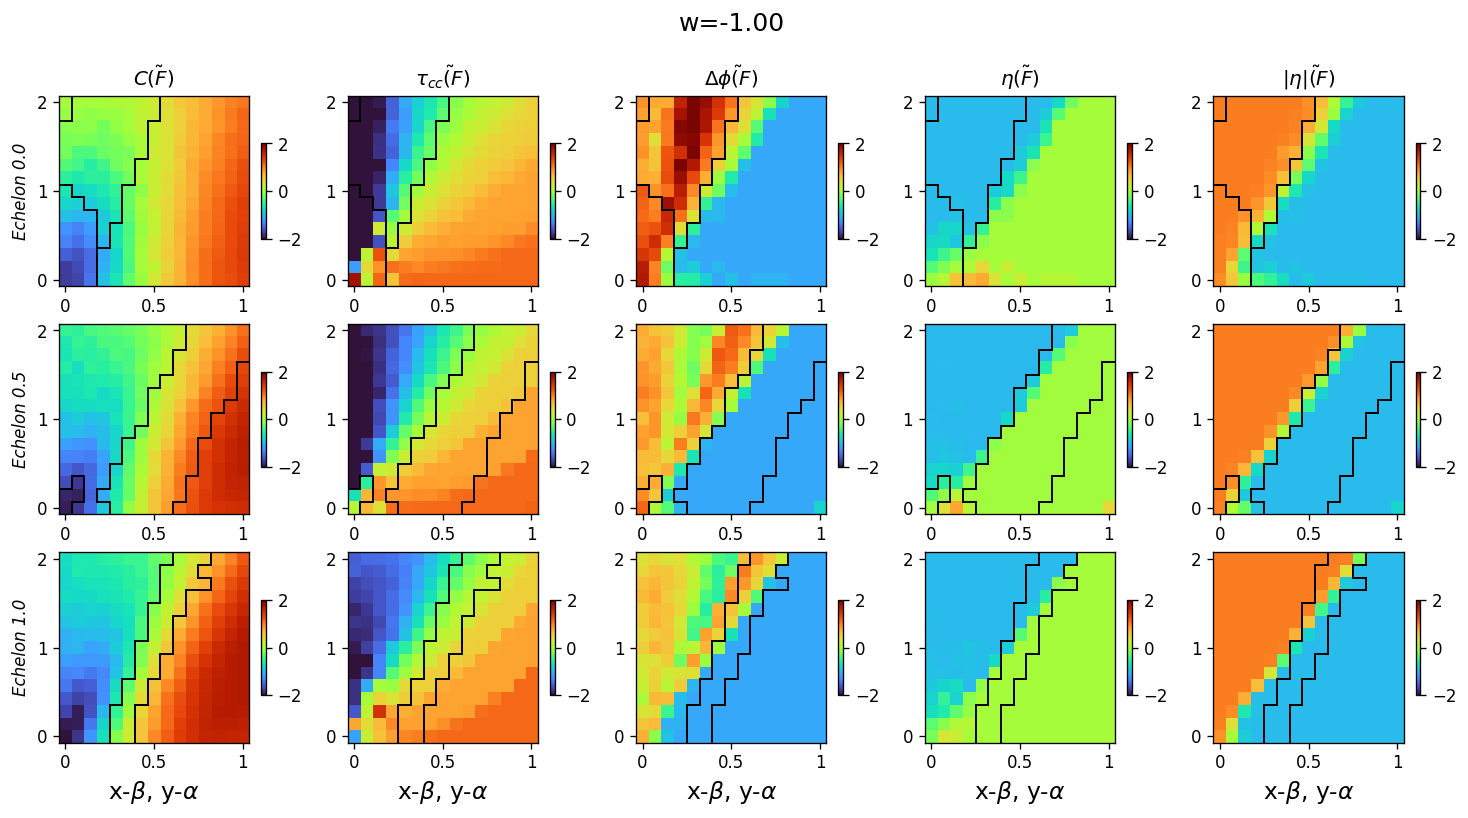

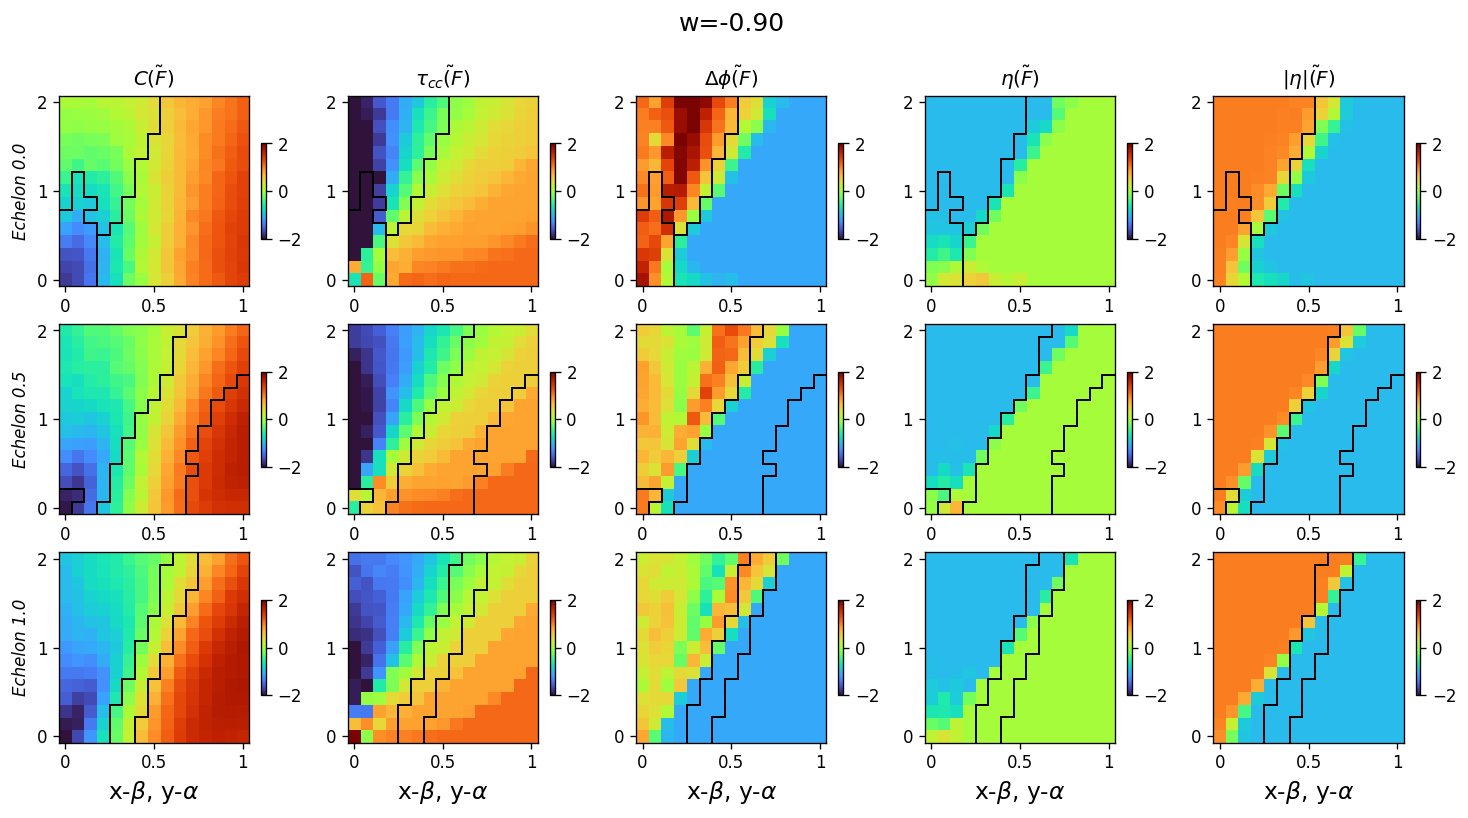

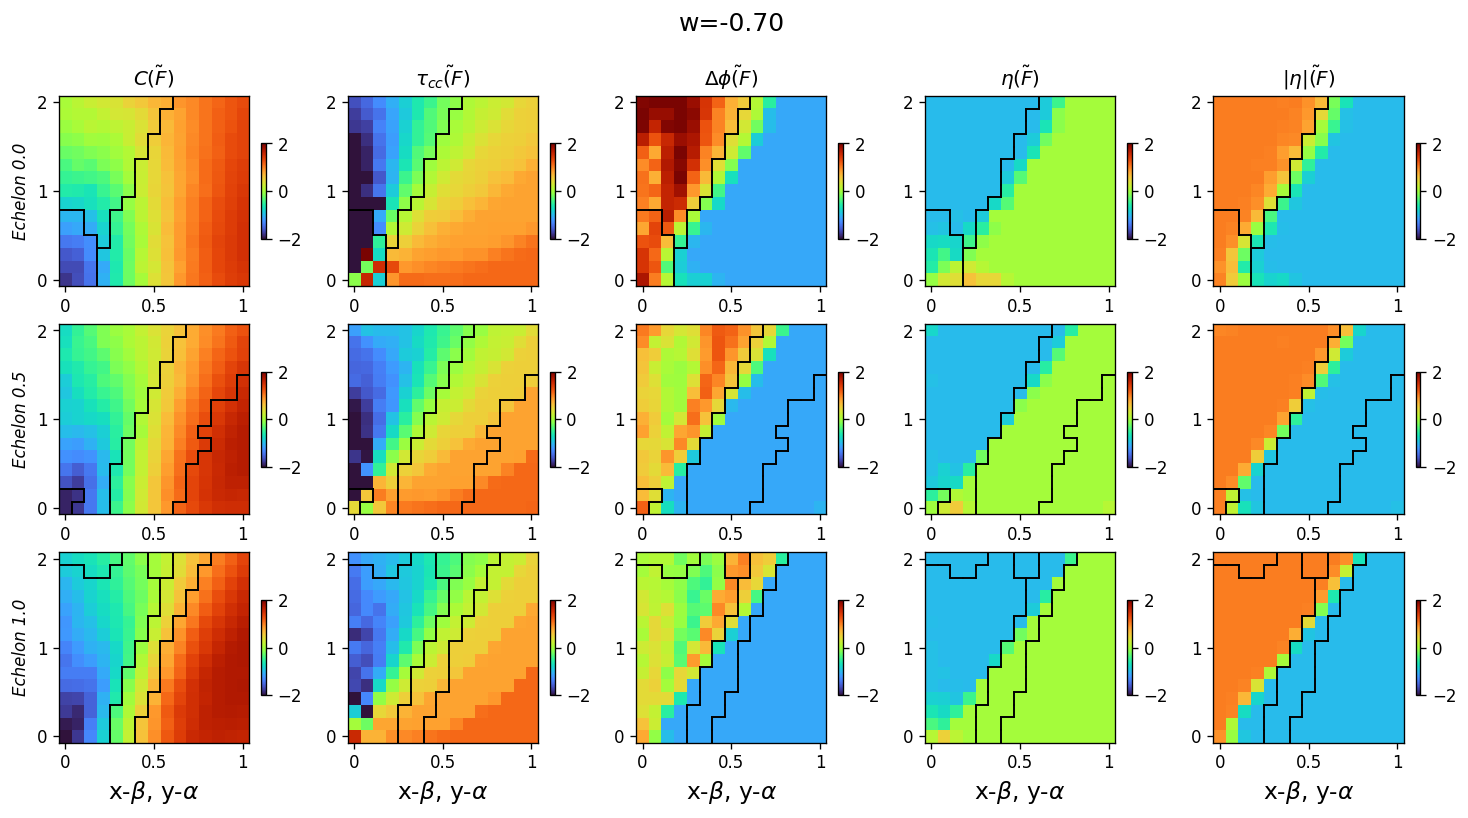

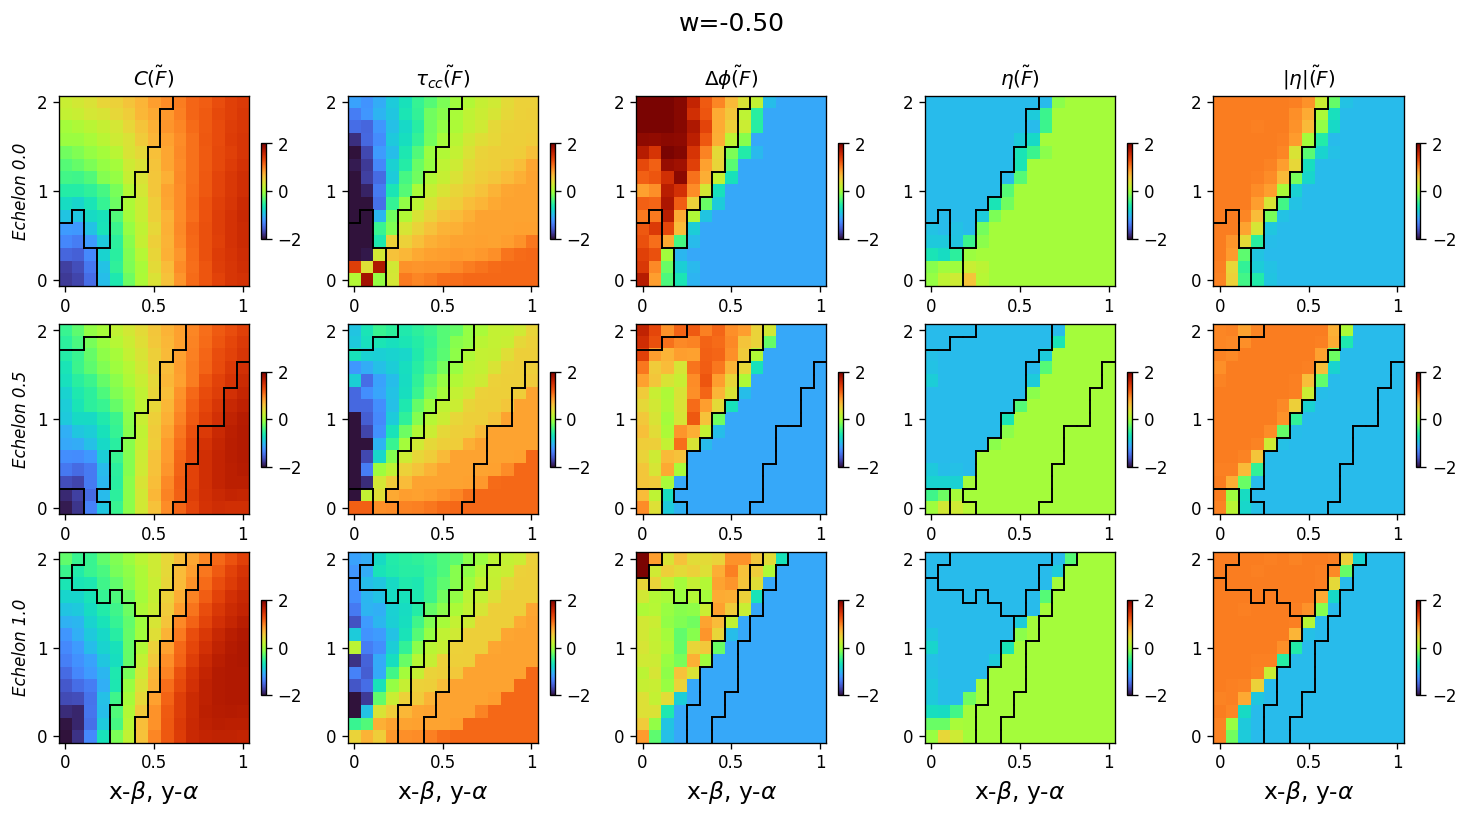

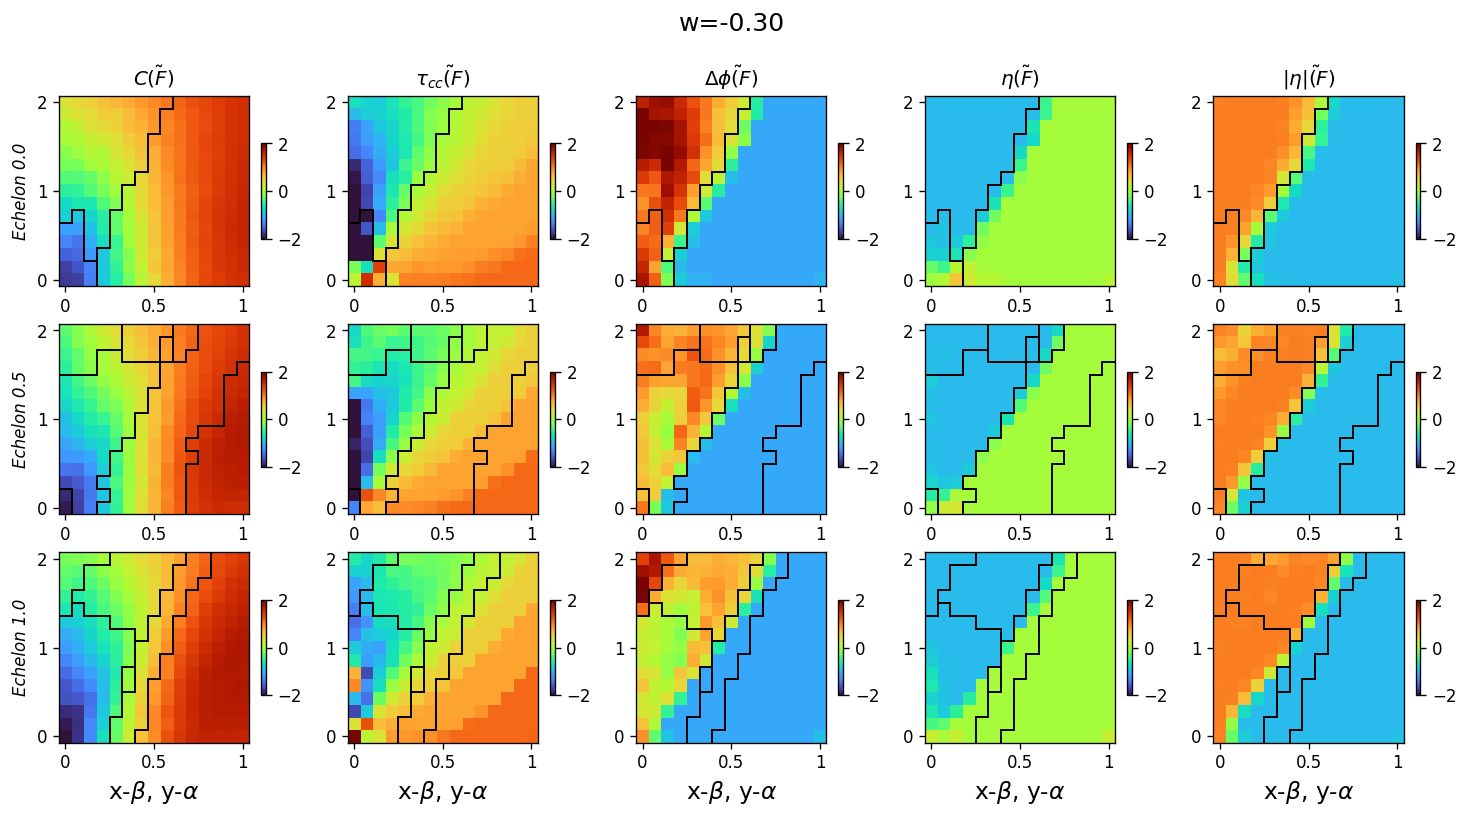

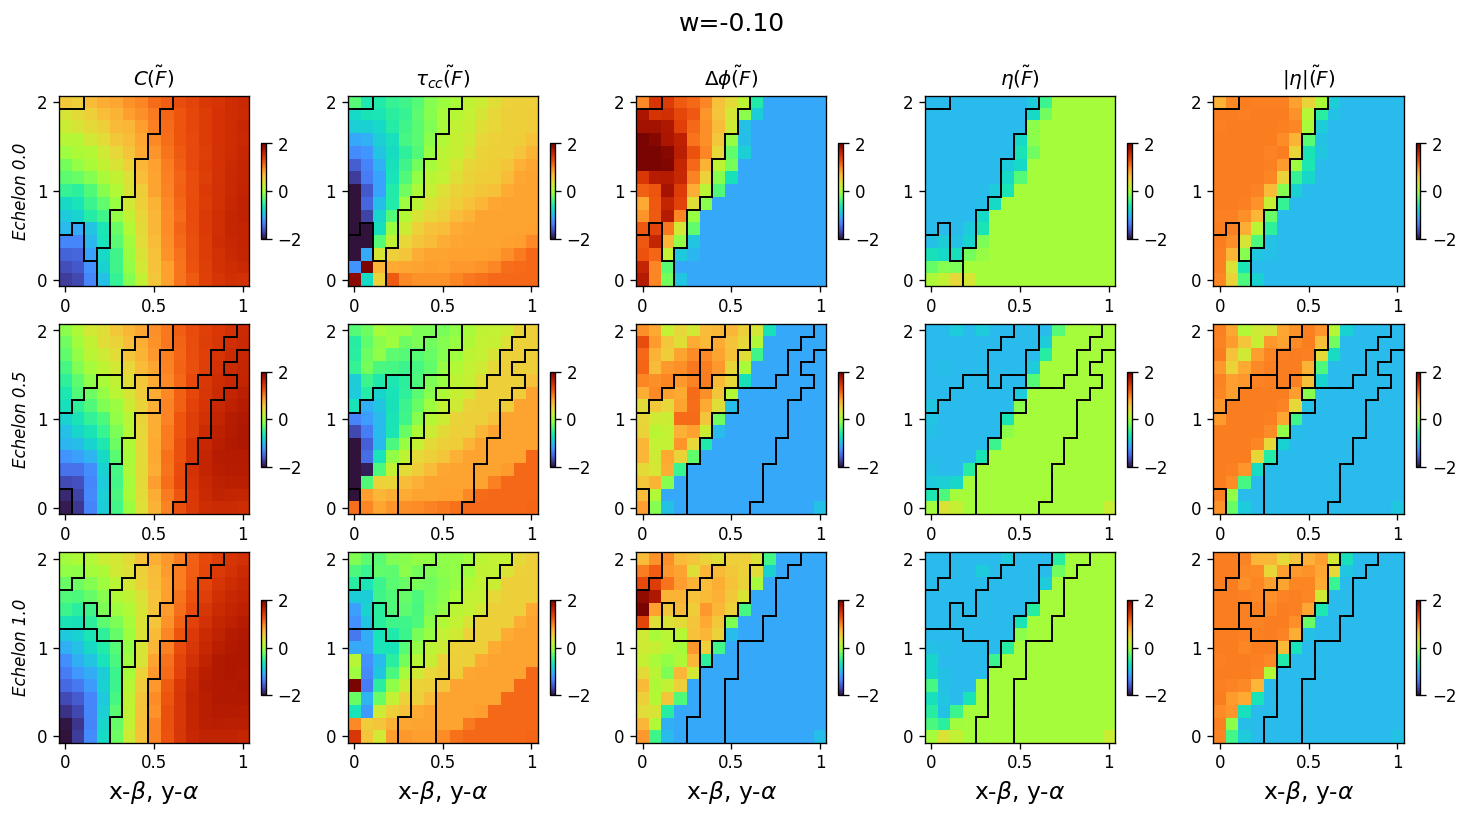

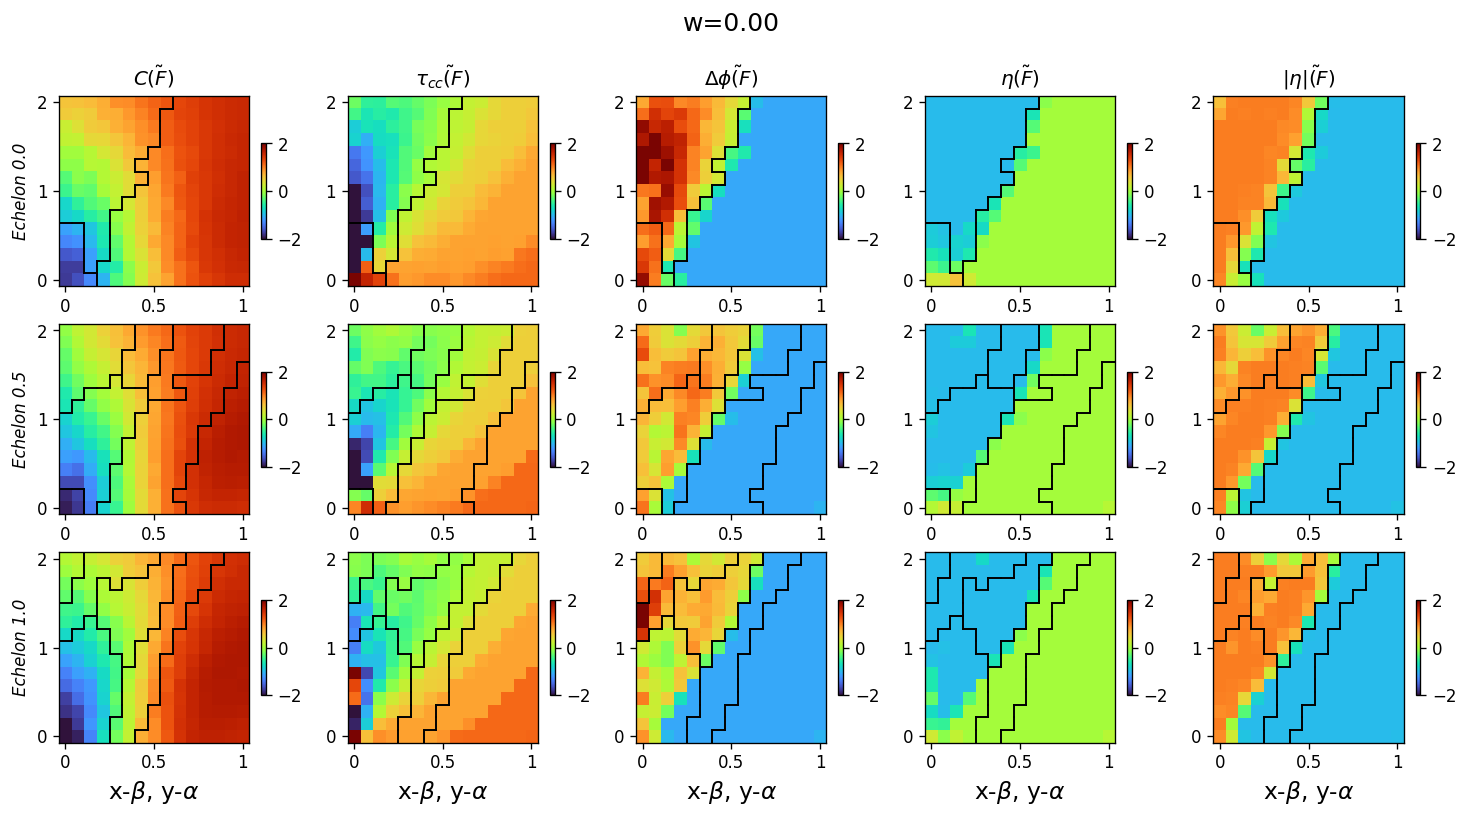

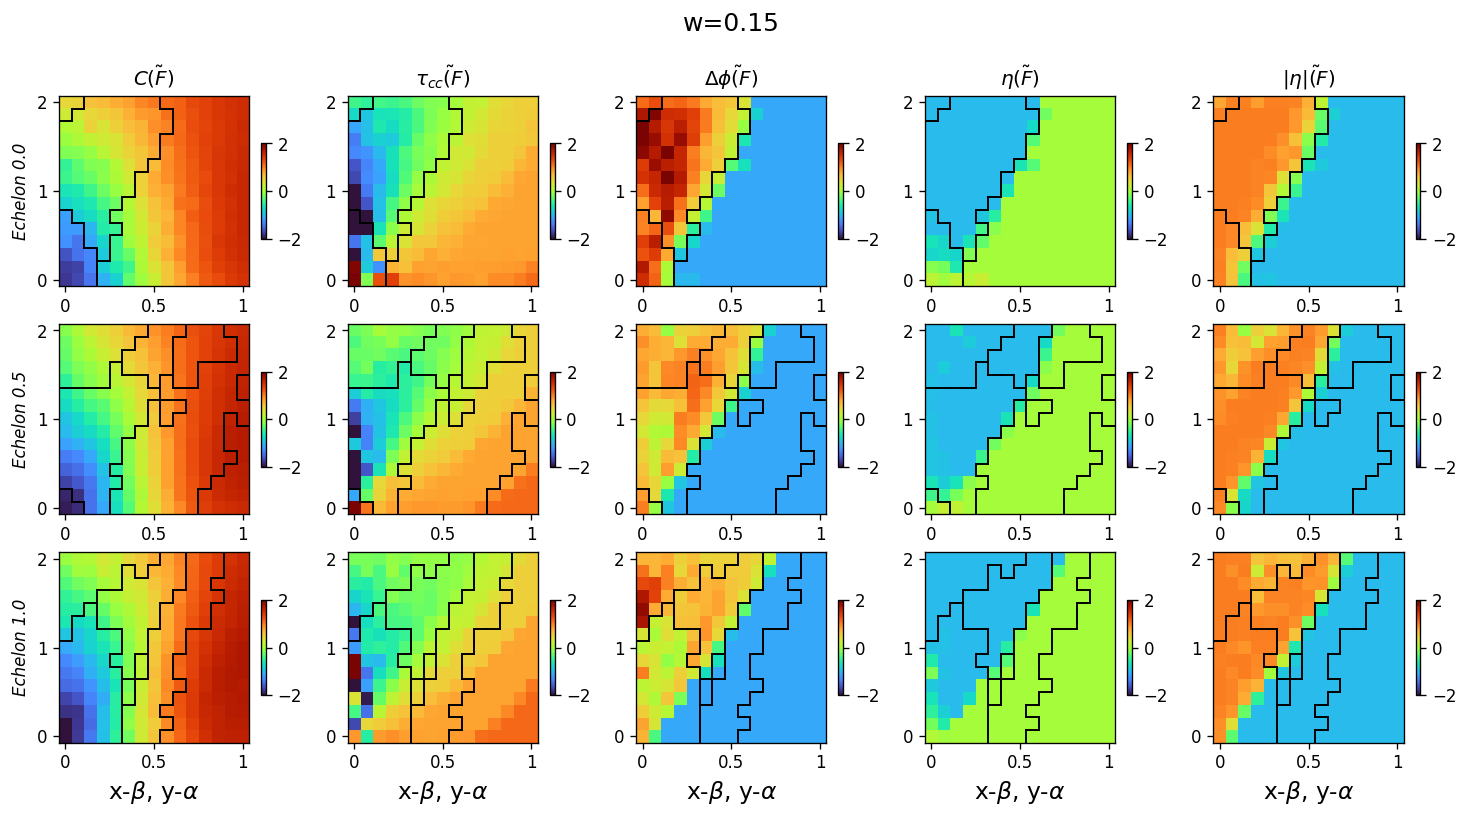

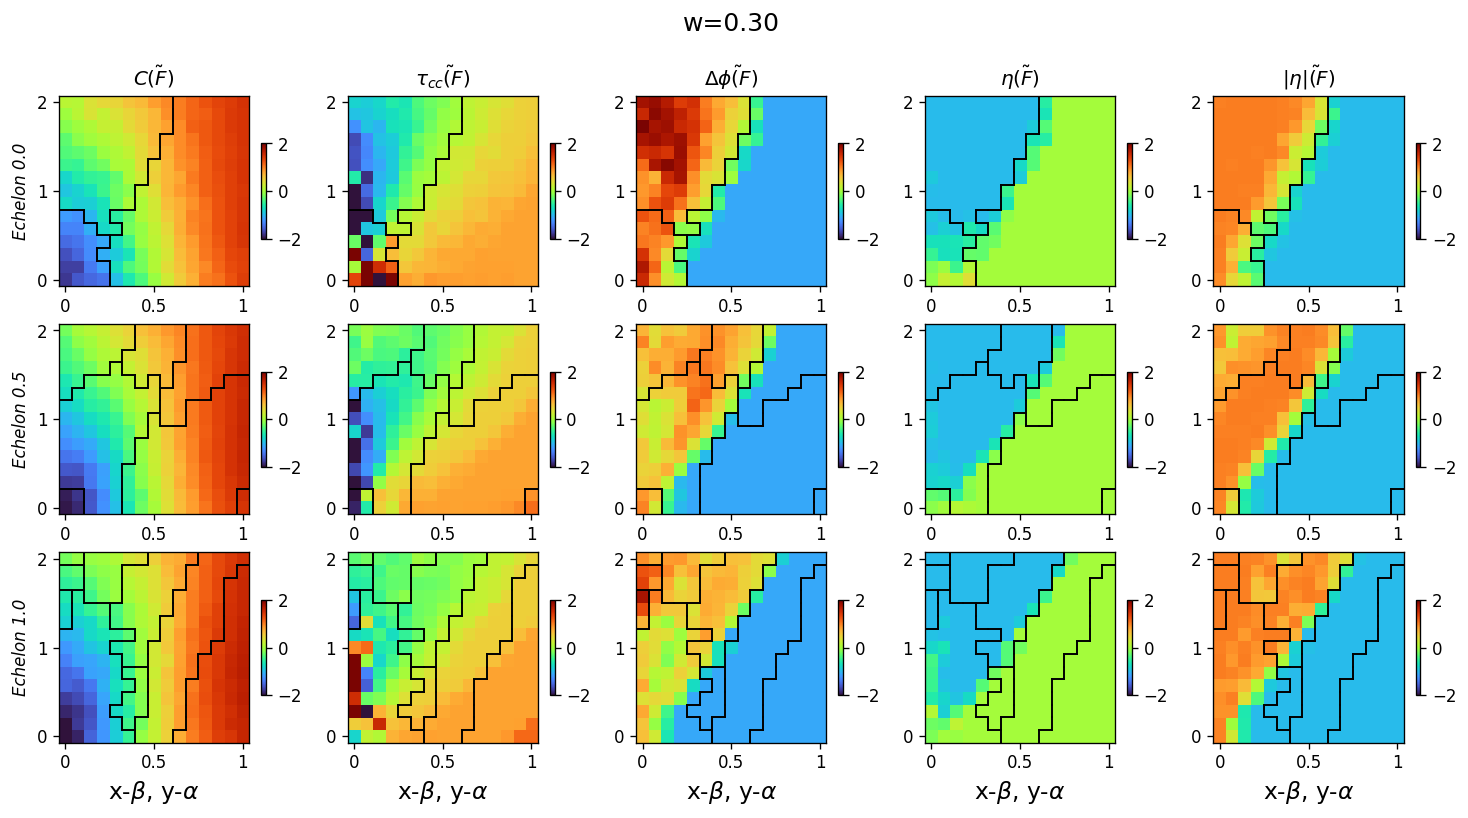

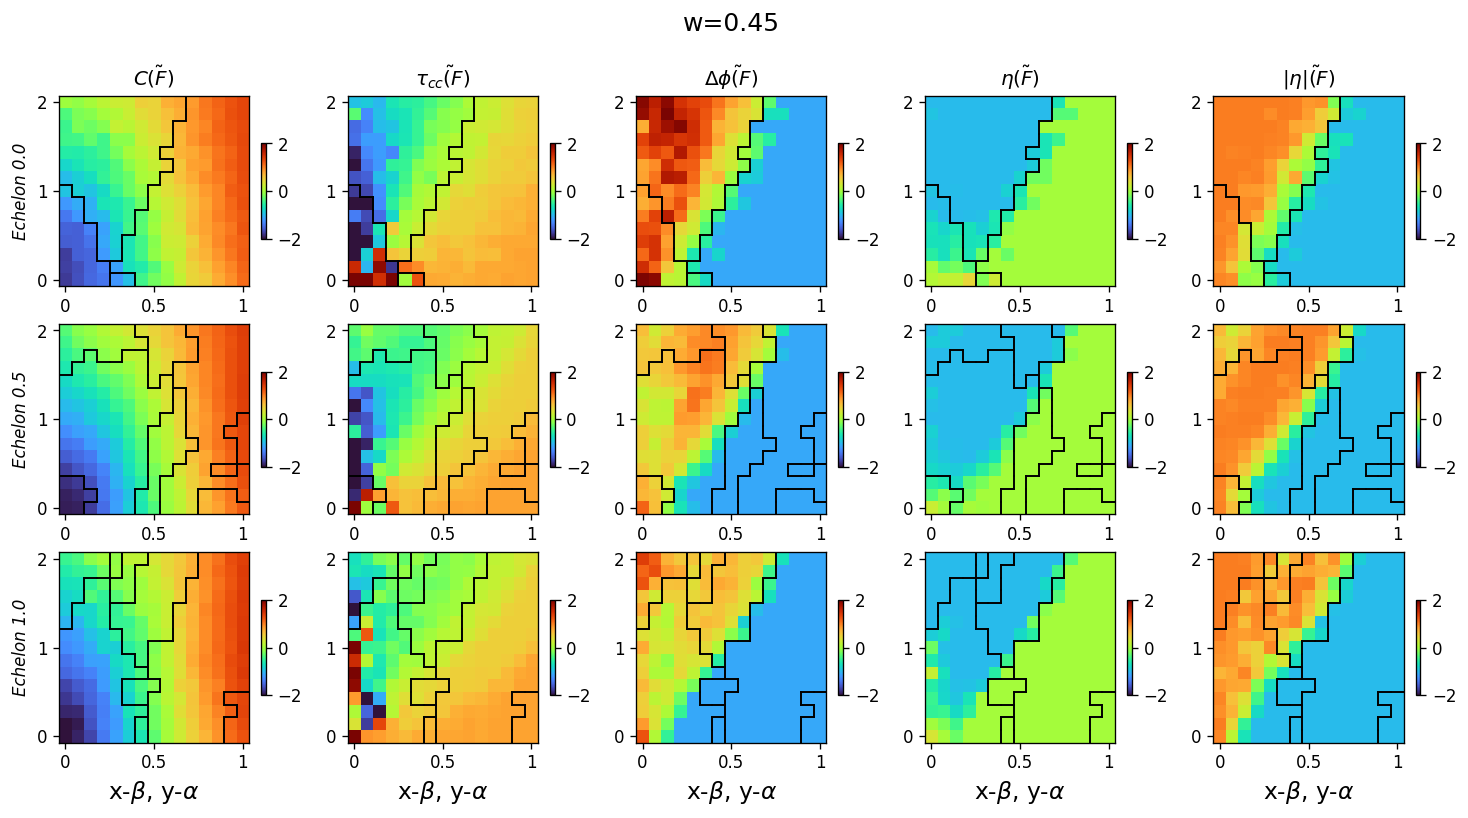

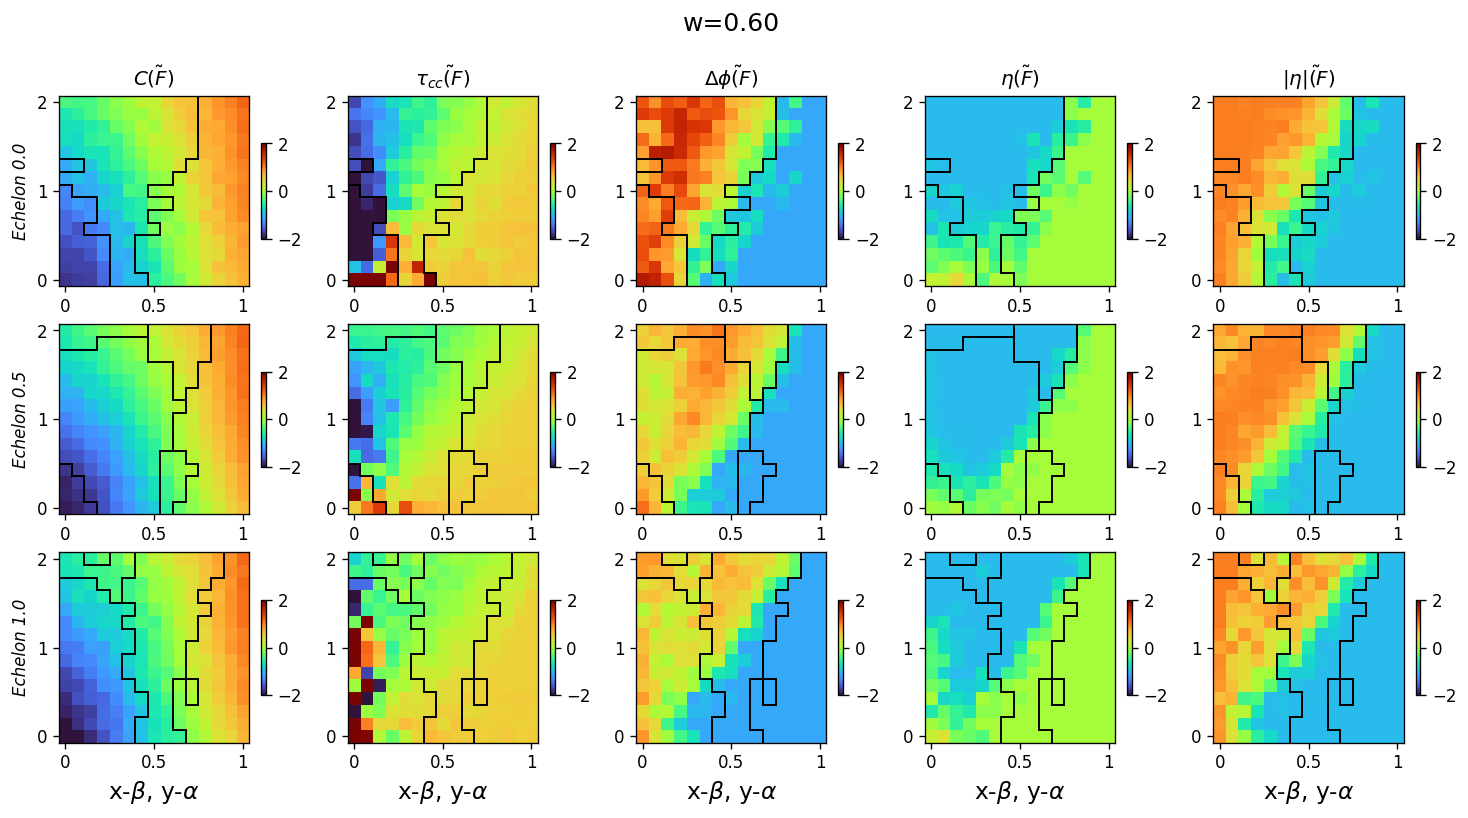

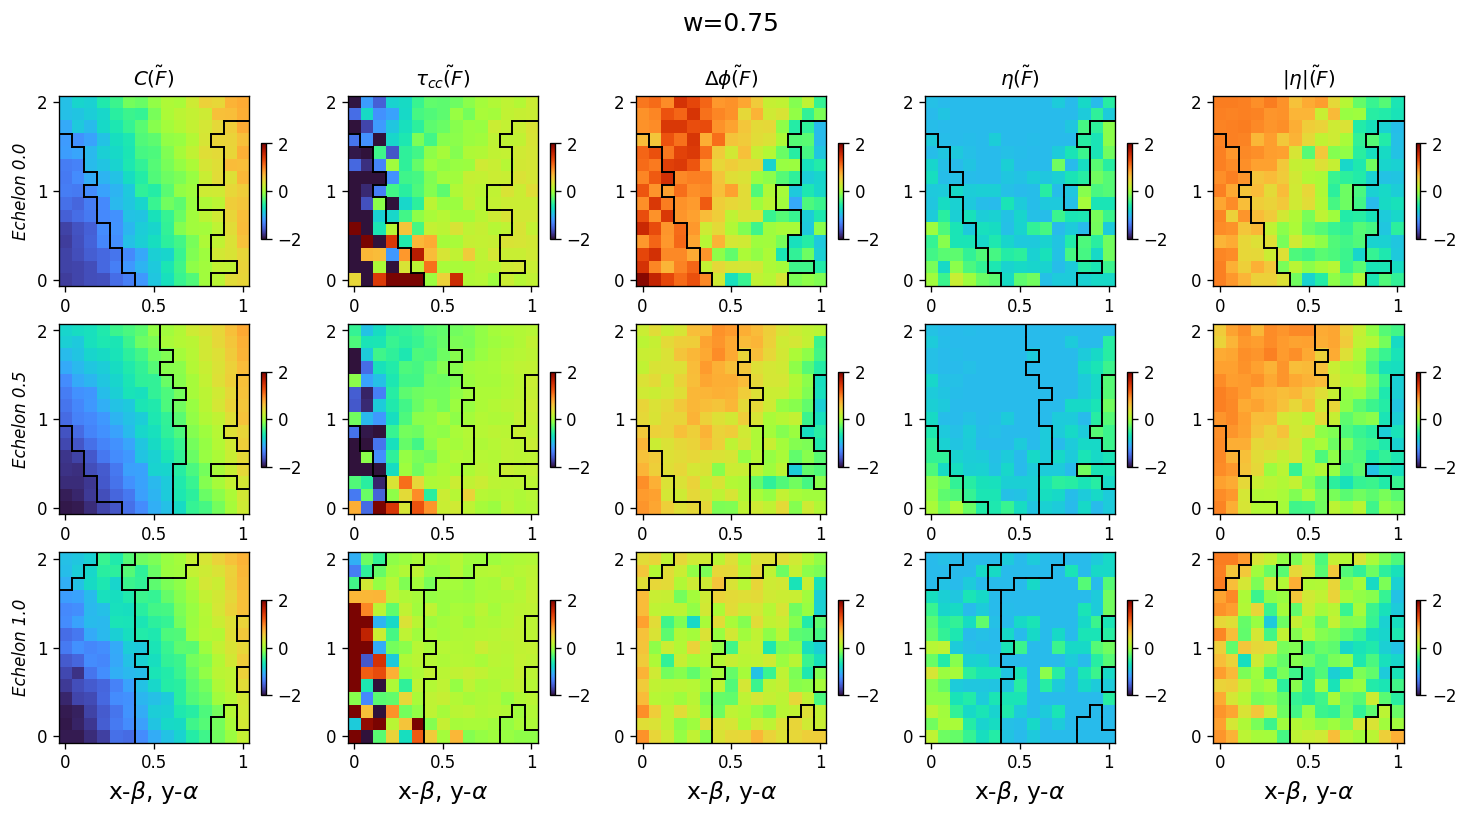

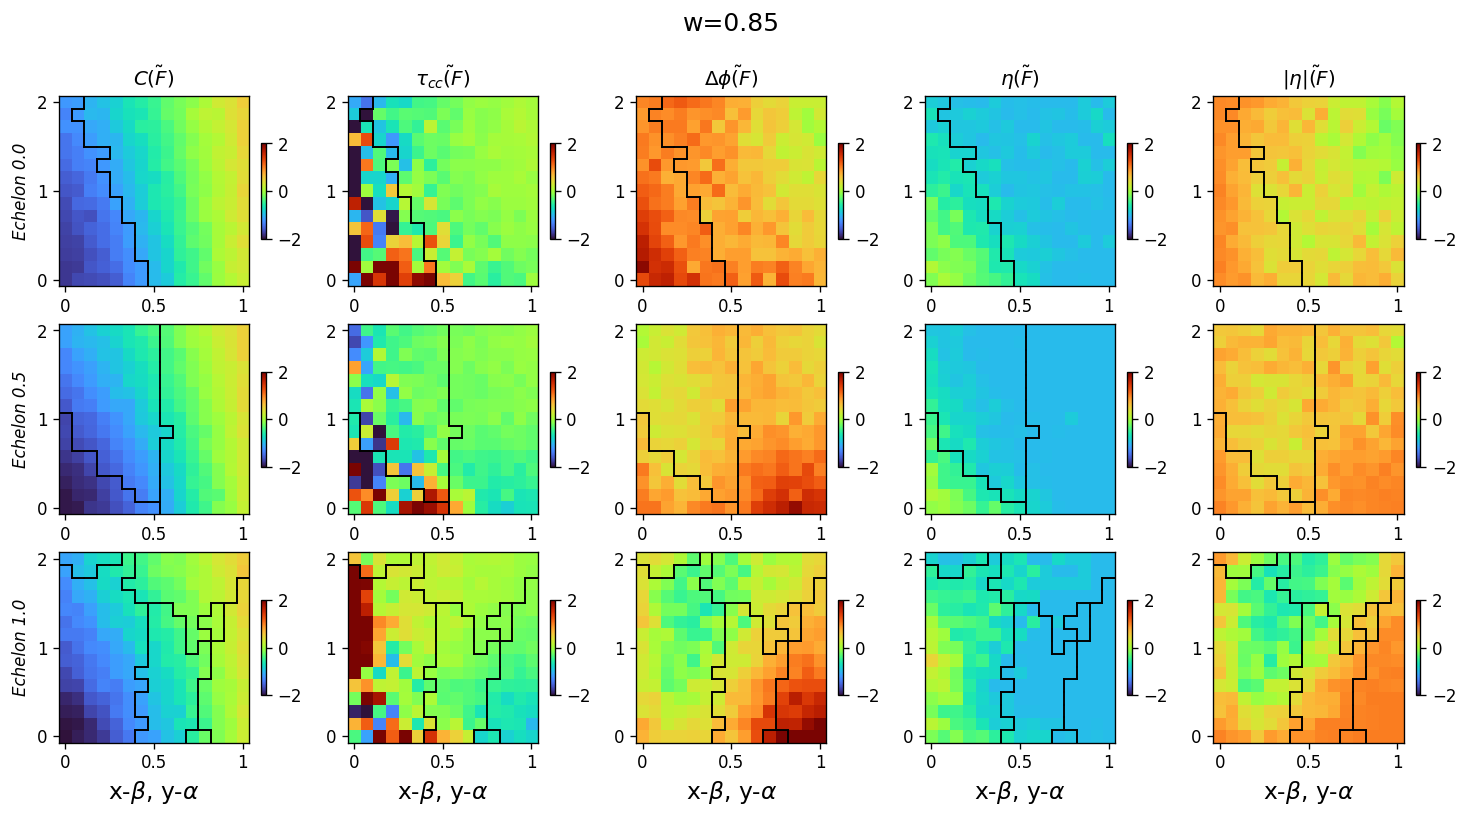

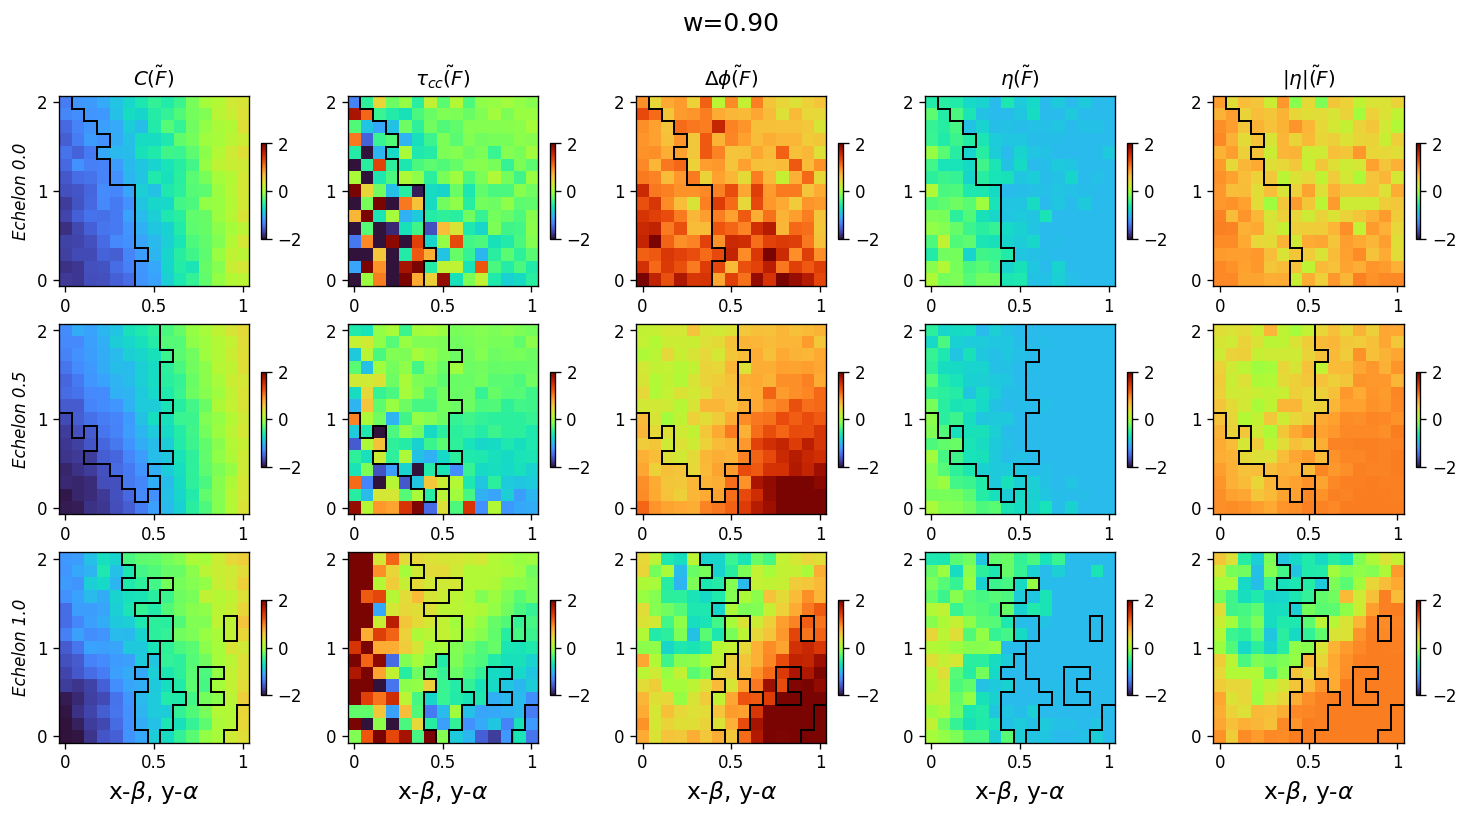

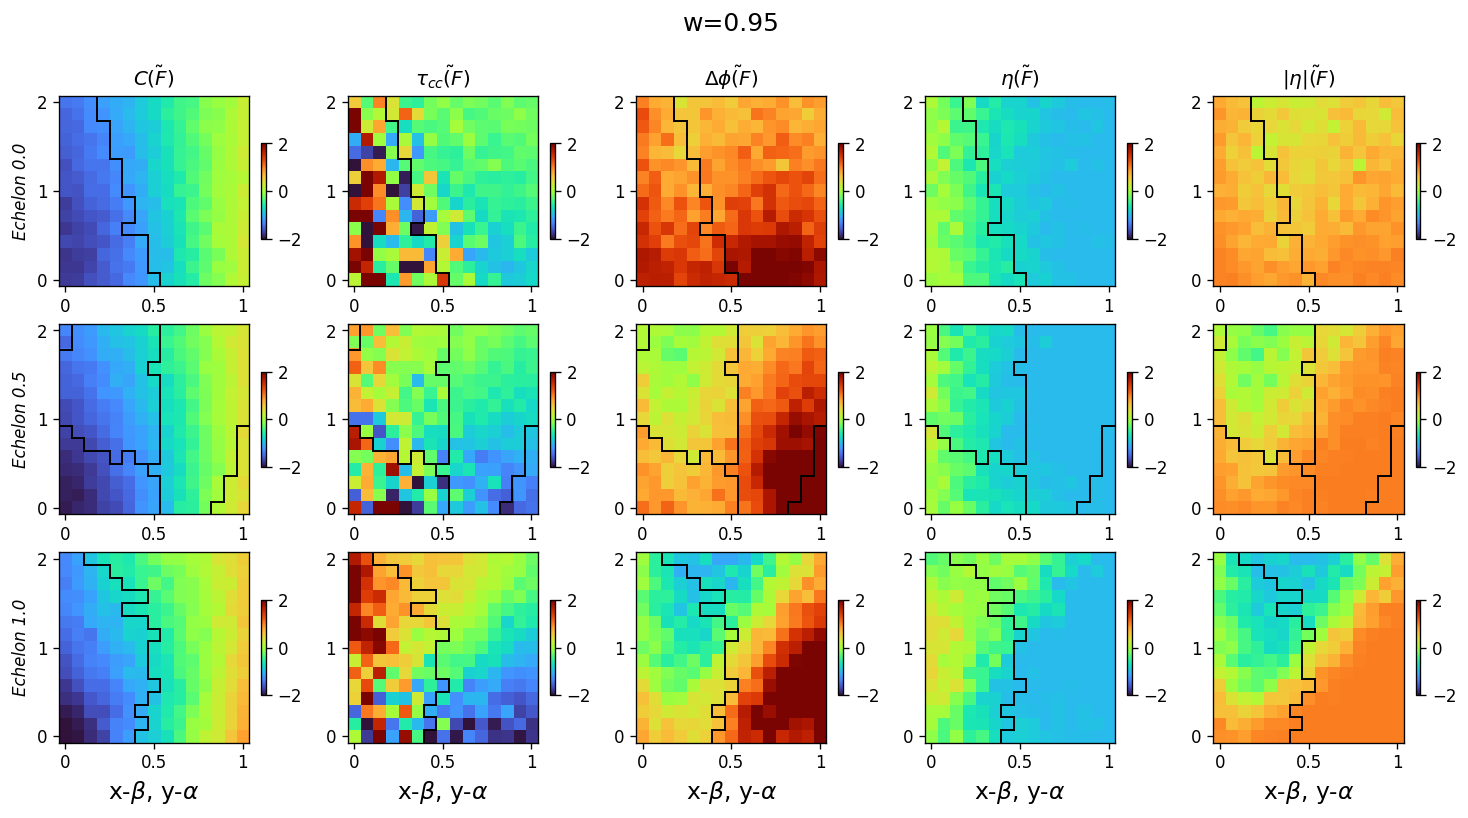

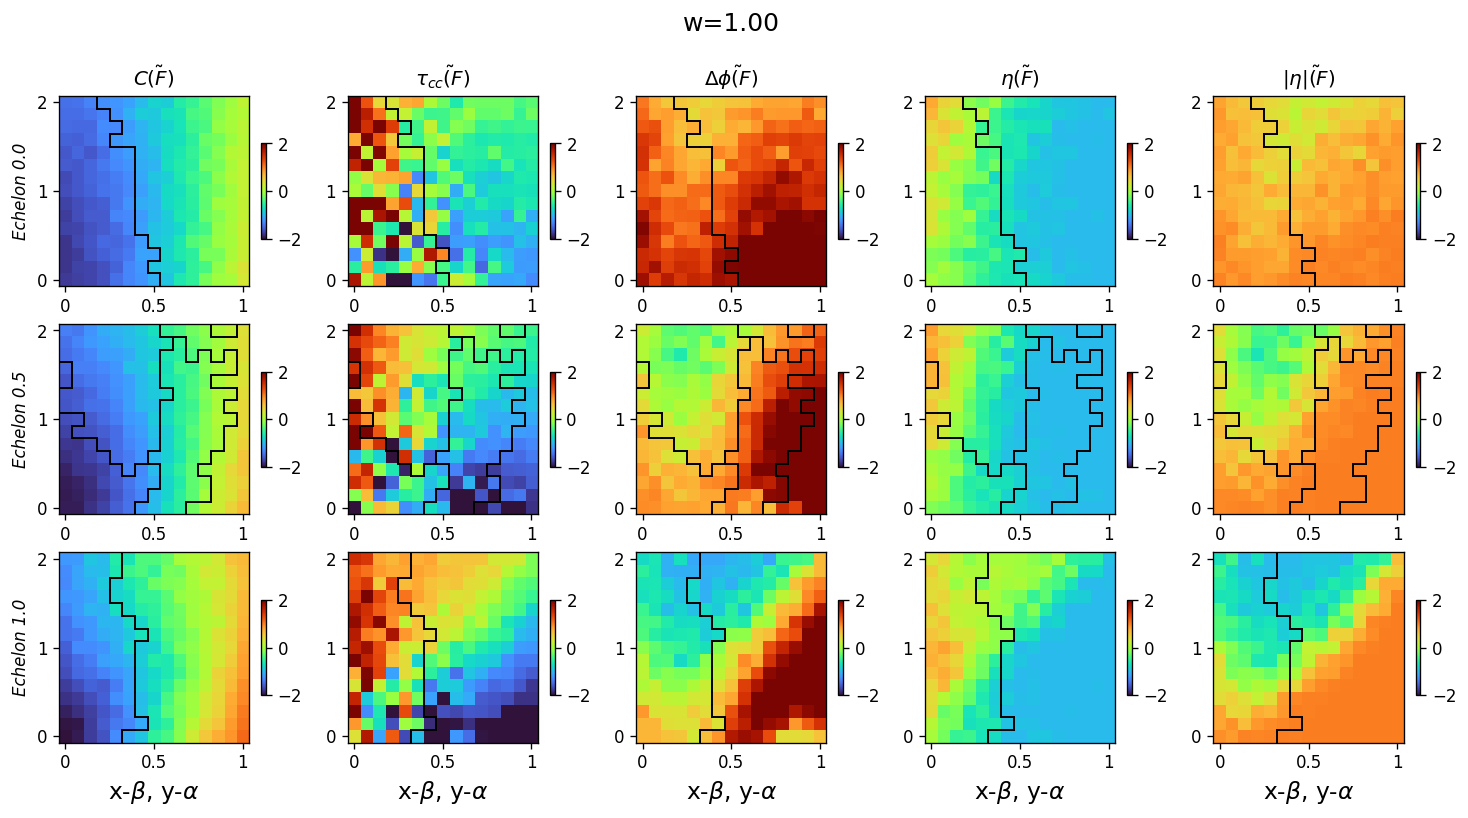

In [49]:
key2show_set = (("chi(F)", "ac2p_large(F)", "tlag_large(F)", "ac2p_1st(F)", "tlag_1st(F)"),
                ("chi(S)", "ac2p_large(S)", "tlag_large(S)", "ac2p_1st(S)", "tlag_1st(S)"),
                ("cc1p(F)", "tlag_cc(F)", "dphi(F)", "leading_ratio(F)", "leading_ratio(abs)(F)"), # if tlag_cc < 0: -> F lead
                ("chi(F)_std", "ac2p_large(F)_std", "tlag_large(F)_std", "ac2p_1st(F)_std", "tlag_1st(F)_std"),
                ("chi(S)_std", "ac2p_large(S)_std", "tlag_large(S)_std", "ac2p_1st(S)_std", "tlag_1st(S)_std"),
                ("cc1p(F)_std", "tlag_cc(F)_std", "dphi(F)_std"))

# wset = postdata.coords["w"]

def id_finder(name, target_name):
    try:
        return name.index(target_name)
    except ValueError:
        print(target_name, "not exist in input")
        return None

key2show = key2show_set[2]

figsize = (len(key2show)*3, 7)

for nw in range(16):
    
    # fname = "./summaryfigs/%s(%s,%s,%d)"%(key_repr_name, pop_type, ftype, nw)
    fig = plt.figure(dpi=120, figsize=figsize)
    
    target_ids = [id_finder(align_data["row_names"], k) for k in key2show]
    
    for nrank in range(3):
        for n, tid in enumerate(target_ids):
            # im = postdata.sel(key=k, type=ftype, pop="F").isel(w=nw, rank=nrank).data
            im = sq_data[tid][:,:,nrank,nw]
            
            plt.subplot(3, len(key2show), nrank*len(key2show)+n+1)
            # hhtools.imshow_sq(im, x=np.linspace(0, 2, 15), y=np.linspace(0.01, 1, 15),
            #                 xt=(0, 1, 2), yt=(0, 0.5, 1), format="%.1f",
            #                 vmin=-3, vmax=3)
            plt.imshow(im, cmap="turbo", vmin=-2, vmax=2, extent=(-0.5, 14.5, -0.5, 14.5), origin="lower")
            plt.xticks([0, 7, 14], labels=(0, 0.5, 1))
            plt.yticks([0, 7, 14], labels=(0, 1, 2))
            
            for l in lines_cluster[nrank][nw]:
                plt.plot(l[0], l[1], 'k', lw=1)
                
            plt.colorbar(shrink=0.5)
            
            if n == 0:
                plt.ylabel("Echelon %.1f"%(nrank/2), style="italic")
            
            if nrank == 0:
                plt.title("$\\tilde{%s}$"%(align_data["row_labels"][tid][1:-1]))
                
            if nrank == 2:
                plt.xlabel(r"x-$\beta$, y-$\alpha$", fontsize=14)
            
    plt.suptitle("w=%.2f"%(wset[nw]), fontsize=15)
    plt.show()

In [ ]:
key2show_set = (())

In [220]:
sq_data.shape

(28, 15, 15, 3, 16)

In [55]:
def restore_order(order):
    rev_order = order[order]
    rev_order = np.zeros_like(order)
    for n, o in enumerate(order):
        rev_order[o] = n
    return rev_order

In [59]:
a = np.arange(12)
b = np.random.choice(a, size=len(a), replace=False)

a1 = a[b]
print(a1)

br = restore_order(b)
print(a1[br])

[11 10  3  7  5  9  4  0  6  2  8  1]
[ 0  1  2  3  4  5  6  7  8  9 10 11]


In [41]:
ro = restore_order(o)
print(ro)

[1 2 0]


In [35]:
ro = restore_order(o)
print(ro)

[1 2 0]


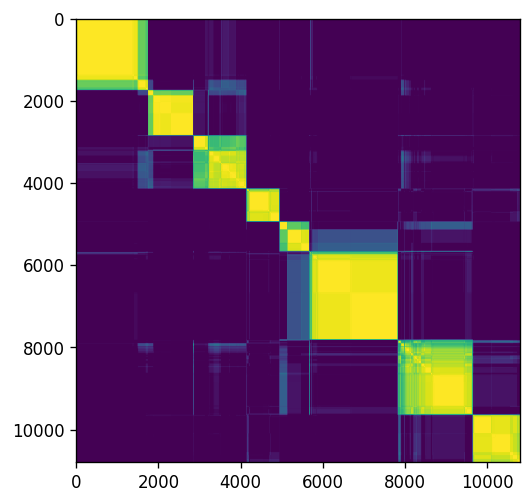

In [28]:
plt.imshow(sorted_mat)

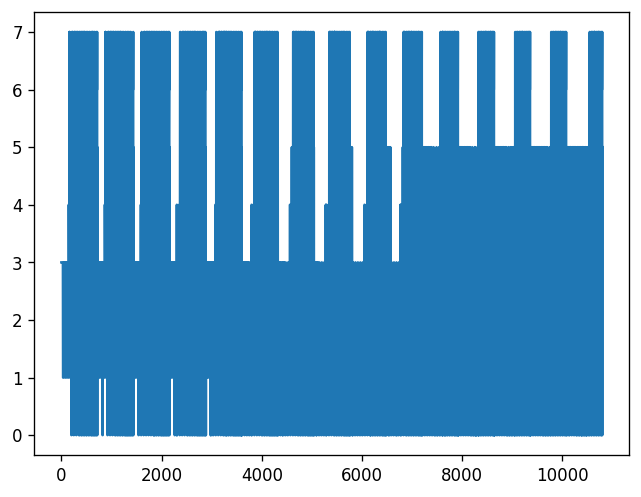

In [25]:
plt.plot(cluster_id)

In [ ]:
clu

In [7]:
cluster_id.shape

(10800,)